In [2]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter
import segmentation_models_3D as sm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import KFold

#### Initial data exploration

In [3]:
TRAIN_DATASET_PATH = '/media/euler/SSD 120GB/BraTS2021/BraTS2021_Training_Data/'
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_00000')

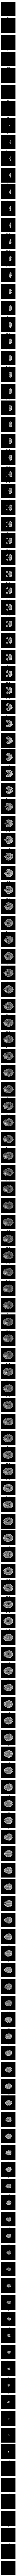

In [4]:
# Load the image
test_image = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_flair.nii.gz').get_fdata()

# Get the number of slices
num_slices = test_image.shape[-1]

# Display the slices
fig, axes = plt.subplots(num_slices, figsize=(6, 3 * num_slices))
for i in range(num_slices):
    axes[i].imshow(test_image[:, :, i], cmap='gray')
    axes[i].set_title(f'Slice {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

As we can see, the first 15 or so slices of the MRI scan carry almost no information, same goes for the final 10

In [7]:
# Load the images
test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_flair.nii.gz').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_t1.nii.gz').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_t2.nii.gz').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_seg.nii.gz').get_fdata()

In [8]:
print(test_image.shape)

(240, 240, 155)


In [9]:
# Define the crop region
crop_region = (slice(34, 206), slice(39, 211), slice(14, 142))

# Crop the images
test_image_flair_cropped = test_image_flair[crop_region]
test_image_t1_cropped = test_image_t1[crop_region]
test_image_t1ce_cropped = test_image_t1ce[crop_region]
test_image_t2_cropped = test_image_t2[crop_region]

# Display the cropped images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(test_image_flair_cropped[:, :, 55], cmap='gray')
axes[0, 0].set_title('Cropped Image (FLAIR)')
axes[0, 1].imshow(test_image_t1_cropped[:, :, 55], cmap='gray')
axes[0, 1].set_title('Cropped Image (T1)')
axes[1, 0].imshow(test_image_t1ce_cropped[:, :, 55], cmap='gray')
axes[1, 0].set_title('Cropped Image (T1CE)')
axes[1, 1].imshow(test_image_t2_cropped[:, :, 55], cmap='gray')
axes[1, 1].set_title('Cropped Image (T2)')
plt.tight_layout()
plt.show()

Here I experimented with the cropping coordinates in order to make it as centered as possible

(128, 128, 128)


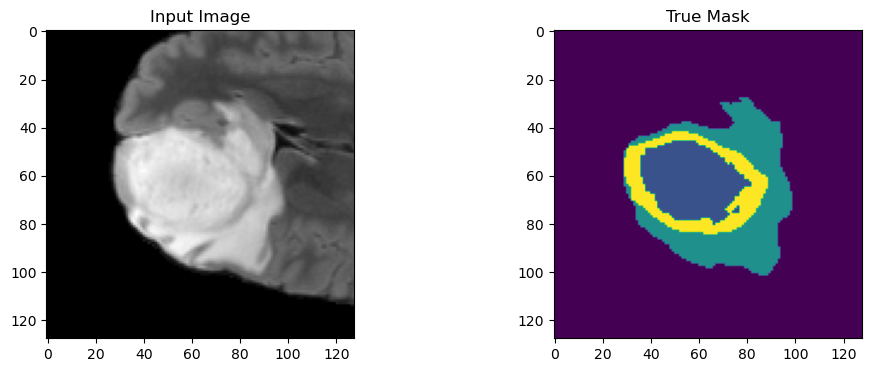

In [12]:
flair = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00006/BraTS2021_00006_flair.nii.gz').get_fdata()
mask = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00006/BraTS2021_00006_seg.nii.gz').get_fdata()
nonzero_coords = np.array(np.nonzero(mask))
center_coords = np.mean(nonzero_coords, axis=1).astype(int)

crop_size = 128
crop_start = center_coords - crop_size // 2
crop_end = crop_start + crop_size

flair_crop = flair[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1], 14:142]
mask_crop = mask[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1], 14:142]
print(mask_crop.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(flair_crop[:, :, 55], cmap='gray')
axes[0].set_title('Input Image')
axes[1].imshow(mask_crop[:, :, 55])
axes[1].set_title('True Mask')
plt.show()

And then experimented with cropping with the tumor as the center

#### Data augmentation functions

In [13]:
def calculate_coords(mask, crop):
    """
    Calculates cropping coordinates based on the parameters given
 
    Parameters:
    - mask (np.array): A 3D array representing the mask
    - crop (str): Specifies the type of cropping. Can be 'tumor' for tumor-centered cropping
                  or 'center' for fixed central cropping.
 
    Returns:
    - A tuple of four integers representing the start and end coordinates for cropping the image
    """
 
    # handles cropping with the tumor as the center
    if crop == 'tumor':
        # finds the coordinates of all non-zero elements in the mask
        nonzero_coords = np.array(np.nonzero(mask))
 
        # if the mask is entirely zeros (there's no tumor/edema) the middle is used as the center
        if np.all(mask == 0):
            center_coords = np.array(mask.shape) // 2
        else:
            # calculates the center of the non-zero elements
            center_coords = np.mean(nonzero_coords, axis=1).astype(int)
 
        # defines the size of the crop area.
        crop_size = 128
 
        # calculates the starting and ending coordinates for the crop area
        crop_start = center_coords - crop_size // 2
        crop_end = crop_start + crop_size
 
        # bounds the coordinates to ensure the crop area stays within the edges of the image
        if crop_start[0] < 0:
            crop_start[0] = 0
            crop_end[0] = crop_size
        if crop_end[0] > 240:
            crop_end[0] = 240
            crop_start[0] = 240 - crop_size
        if crop_start[1] < 0:
            crop_start[1] = 0
            crop_end[1] = crop_size
        if crop_end[1] > 240:
            crop_end[1] = 240
            crop_start[1] = 240 - crop_size
 
        # calculated coordinates are returned
        return crop_start[0], crop_end[0], crop_start[1], crop_end[1]
 
    # handles cropping with the middle of the image as the center
    if crop == 'center':
        # fixed coordinates are returned
        return 56, -56, 56, -56

In [14]:
def load_data(folder_path, folder_name):
    """
    Loads MRI scans and their segmentation mask from a specified folder
    
    Parameters:
    - folder_path (str): The path to the folder containing the files
    - folder_name (str): The base name of the files to load
    
    Returns:
    - tuple: Contains the data from flair, t1, t1ce, t2 and the mask
    """
    
    # constructs the full file paths for each MRI scan and the segmentation mask
    flair_path = os.path.join(folder_path, folder_name + '_flair.nii.gz')
    t1_path = os.path.join(folder_path, folder_name + '_t1.nii.gz')
    t1ce_path = os.path.join(folder_path, folder_name + '_t1ce.nii.gz')
    t2_path = os.path.join(folder_path, folder_name + '_t2.nii.gz')
    mask_path = os.path.join(folder_path, folder_name + '_seg.nii.gz')

    # loads each scan using Nibabel and retrieves the data as an array
    flair = nib.load(flair_path).get_fdata()
    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    
    # returns the loaded data
    return flair, t1, t1ce, t2, mask

In [15]:
def normalize_data(flair, t1, t1ce, t2):
    """
    Normalizes MRI scan data to a [0, 1] range using min-max scaling
    
    Parameters:
    - flair, t1, t1ce, t2 (numpy.ndarray): Arrays representing MRI scans of types FLAIR, T1, T1CE, and T2
    
    Returns:
    - tuple: Contains the normalized data for the FLAIR, T1, T1CE, and T2 scans
    """
    
    # initializes MinMaxScaler
    scaler = MinMaxScaler()
    
    # normalizes FLAIR scan data:
    # first, it reshapes the data to a 2D array where each row represents a voxel and each column a slice
    # then, it fits the scaler to the data and transforms it
    # finally, it reshapes the normalized data back to its original shape
    flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
    
    # we repeat the normalization process for t1, t1ce and t2
    t1 = scaler.fit_transform(t1.reshape(-1, t1.shape[-1])).reshape(t1.shape)
    t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
    t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
    
    # returns the normalized scans as a tuple
    return flair, t1, t1ce, t2

In [16]:
def flip_image(flair, t1, t1ce, t2, mask):
    """
    Randomly flips the MRI scans and their corresponding mask along a chosen axis

    Parameters:
    - flair, t1, t1ce, t2, mask (numpy.ndarray): Input arrays representing MRI scans and their segmentation mask
    
    Returns:
    - tuple: Contains the flipped images for flair, t1, t1ce, t2 and the mask
    """
    
    # chooses an axis to flip the images randomly
    axis = random.choice(['x', 'y', 'z'])
    
    # flips the images along the x-axis
    if axis == 'x':
        flair = np.flip(flair, axis=0)
        t1 = np.flip(t1, axis=0)
        t1ce = np.flip(t1ce, axis=0)
        t2 = np.flip(t2, axis=0)
        mask = np.flip(mask, axis=0)
    
    # flips the images along the y-axis
    elif axis == 'y':
        flair = np.flip(flair, axis=1)
        t1 = np.flip(t1, axis=1)
        t1ce = np.flip(t1ce, axis=1)
        t2 = np.flip(t2, axis=1)
        mask = np.flip(mask, axis=1)
    
    # flips the images along the z-axis
    elif axis == 'z':
        flair = np.flip(flair, axis=2)
        t1 = np.flip(t1, axis=2)
        t1ce = np.flip(t1ce, axis=2)
        t2 = np.flip(t2, axis=2)
        mask = np.flip(mask, axis=2)
    
    # returns the flipped images
    return flair, t1, t1ce, t2, mask

In [17]:
def brightness_alter(flair, t1, t1ce, t2):
    """
    Alters the brightness of MRI scan images by a random factor
    
    Parameters:
    - flair, t1, t1ce, t2 (numpy.ndarray): Input arrays representing the MRI scans
      
    Returns:
    - tuple: Contains the brightness-adjusted images for flair, t1, t1ce and t2
    """
    
    # randomly chooses a factor between 0.7 and 1.3
    factor = random.uniform(0.7, 1.3)
    
    # adjusts the brightness of each modality by that factor
    flair = np.sign(flair) * factor * (np.abs(flair) ** factor)
    t1 = np.sign(t1) * factor * (np.abs(t1) ** factor)
    t1ce = np.sign(t1ce) * factor * (np.abs(t1ce) ** factor)
    t2 = np.sign(t2) * factor * (np.abs(t2) ** factor)
    
    # returns the altered images
    return flair, t1, t1ce, t2

In [18]:
def apply_contrast(data_sample):
    """
    Applies a change of contrast to an MRI image
    
    Parameters:
    - data_sample (numpy.ndarray): A multi-dimensional array containing the MRI image
      
    Returns:
    - numpy.ndarray: Contains the contrast-adjusted image array
    """
    
    # chooses a random contrast factor between 0.65 and 1.5
    factor = np.random.uniform(0.65, 1.5)
    
    # applies the contrast change to each channel
    for c in range(data_sample.shape[0]):
        # calculates the mean, minimum, and maximum of the current channel
        mn = data_sample[c].mean()
        minm = data_sample[c].min()
        maxm = data_sample[c].max()
        
        # adjusts the contrast and ensure values remain within the original data range
        data_sample[c] = (data_sample[c] - mn) * factor + mn
        # clips values below the original minimum
        data_sample[c][data_sample[c] < minm] = minm
        # clips values above the original maximum
        data_sample[c][data_sample[c] > maxm] = maxm
    
    # returns the image with the contrast change applied
    return data_sample

In [19]:
def contrast_alter(flair, t1, t1ce, t2):
    """
    The function serves as a wrapper to process each MRI scan through the apply_contrast function

    Parameters:
    - flair, t1, t1ce, t2 (numpy.ndarray): Input arrays representing flair, t1, t1ce and t2

    Returns:
    - tuple: Contains the contrast-adjusted volumes for flair, t1, t1ce and t2
    """
    
    # calls apply_contrast for each volume
    flair = apply_contrast(flair)
    t1 = apply_contrast(t1)
    t1ce = apply_contrast(t1ce)
    t2 = apply_contrast(t2)

    # returns the adjusted volumes
    return flair, t1, t1ce, t2

In [20]:
def gaussian_noise(flair, t1, t1ce, t2):
    """
    Adds Gaussian noise to each MRI modality (FLAIR, T1, T1CE, T2).

    Parameters:
    - flair, t1, t1ce, t2 (numpy.ndarray): Input arrays representing flair, t1, t1ce and t2

    Returns:
    - tuple: Contains the noise-augmented volumes for flair, t1, t1ce and t2
    """
    
    # generates the gaussian noise with a randomly chosen standard deviation within 0 and 0.33
    std_dev = random.uniform(0, 0.33)
    noise = np.random.normal(0, std_dev, flair.shape)

    # adds the generated noise to each volume
    for c in range(flair.shape[2]):
        flair[:, :, c] = flair[:, :, c] + noise[:, :, c]
        t1[:, :, c] = t1[:, :, c] + noise[:, :, c]
        t1ce[:, :, c] = t1ce[:, :, c] + noise[:, :, c]
        t2[:, :, c] = t2[:, :, c] + noise[:, :, c]

    # returns the noise-augmented volumes
    return flair, t1, t1ce, t2

In [21]:
def gaussian_blur(flair, t1, t1ce, t2):
    """
    Applies gaussian blur by convolving each image with a gaussian function
    
    Parameters:
    - flair, t1, t1ce, t2 (numpy.ndarray): Input arrays representing flair, t1, t1ce and t2
    
    Returns:
    - tuple of numpy.ndarray: Contains the blurred images for flair, t1, t1ce and t2
    """
    
    # randomly selects a standard deviation for the gaussian blur within 0.5 and 1.5
    std_dev = random.uniform(0.5, 1.5)

    # applies gaussian blur to each volume
    flair = gaussian_filter(flair, sigma=std_dev)
    t1 = gaussian_filter(t1, sigma=std_dev)
    t1ce = gaussian_filter(t1ce, sigma=std_dev)
    t2 = gaussian_filter(t2, sigma=std_dev)

    # returns the blurred volumes
    return flair, t1, t1ce, t2

In [22]:
def augment_data(flair, t1, t1ce, t2, mask):
    """
    Applies a single random augmentation to flair, t1, t1ce, t2 and their corresponding mask

    Parameters:
    - flair, t1, t1ce, t2 (numpy.ndarray): Input arrays representing flair, t1, t1ce and t2
    - mask (numpy.ndarray): The segmentation mask for the MRI scans

    Returns:
    - tuple: Contains the possibly augmented images for flair, t1, t1ce and t2 and their mask
    """
    
    # applies image flipping with a 50% chance
    if random.random() < 0.5:
        flair, t1, t1ce, t2, mask = flip_image(flair, t1, t1ce, t2, mask)
    
    # changes brightness with a 15% chance
    elif random.random() < 0.15:
        flair, t1, t1ce, t2 = brightness_alter(flair, t1, t1ce, t2)
    
    # changes contrast with a 15% chance
    elif random.random() < 0.15:
        flair, t1, t1ce, t2 = contrast_alter(flair, t1, t1ce, t2)
    
    # adds gaussian noise with a 15% chance
    elif random.random() < 0.15:
        flair, t1, t1ce, t2 = gaussian_noise(flair, t1, t1ce, t2)
    
    # adds gaussian blur with a 15% chance
    elif random.random() < 0.15:
        flair, t1, t1ce, t2 = gaussian_blur(flair, t1, t1ce, t2)
    
    # returns the (possibly) augmented images and mask
    return flair, t1, t1ce, t2, mask

#### Data generator

In [23]:
def data_generator(folder_names, batch_size, crop, augment):
    """
    Generator function for yielding batches of stacked MRI scans and their masks in
    a format ready for training
 
    Parameters:
    - folder_names (list): List of the folder name containing the data
    - batch_size (int): The size of the batch to yield
    - crop (str): Specifies the type of cropping to apply
    - augment (str): Indicates whether to apply data augmentation ('yes' or 'no')
 
    Yields:
    - tuple: A batch of stacked MRI scans and their corresponding masks as numpy arrays.
    """
    
    while True:
        images = []
        masks = []
        # shuffles folder names to ensure random batches
        np.random.shuffle(folder_names)
 
        for folder_name in folder_names:
            # constructs the full folder path
            folder_path = os.path.join(data_path, folder_name)
 
            if os.path.isdir(folder_path):
                # loads the MRI scans and mask
                flair, t1, t1ce, t2, mask = load_data(folder_path, folder_name)
 
                # applies data augmentation (optionally)
                if augment == 'yes':
                    flair, t1, t1ce, t2, mask = augment_data(flair, t1, t1ce, t2, mask)
 
                # calculates the coordinates for cropping
                top, bottom, left, right = calculate_coords(mask, crop)
                # cropping is applied
                flair = flair[top:bottom, left:right, 14:142]
                t1 = t1[top:bottom, left:right, 14:142]
                t1ce = t1ce[top:bottom, left:right, 14:142]
                t2 = t2[top:bottom, left:right, 14:142]
                mask = mask[top:bottom, left:right, 14:142]
 
                # normalizes the MRI scans
                flair, t1, t1ce, t2 = normalize_data(flair, t1, t1ce, t2)
 
                # prepares the mask for training
                mask = mask.astype(np.uint8)
                # converts class '4' to '3' (classes are 0, 1, 2, 4)
                mask[mask == 4] = 3
                # converts to one-hot encoding
                mask = to_categorical(mask, num_classes=4)  
 
                # stacks MRI scans into a single array
                image = np.stack([flair, t1, t1ce, t2], axis=3)
 
                # appends the processed image and mask to the batch
                images.append(image)
                masks.append(mask)
 
                # yields the batch if it reaches the specified size
                if len(images) == batch_size:
                    yield (np.array(images), np.array(masks))
                    images = []  # reset for the next batch
                    masks = []   # reset for the next batch

#### Loads in the full dataset for training

In [24]:
batch_size = 1
data_path = '/media/euler/SSD 120GB/BraTS2021/BraTS2021_Training_Data/'
dataset_directories = [f.path for f in os.scandir(data_path) if f.is_dir()]

def get_folder_ids(dir_list):
    x = []
    for i in range(0,len(dir_list)):
        x.append(dir_list[i][dir_list[i].rfind('/')+1:])
    return x

train_and_test_ids = get_folder_ids(dataset_directories); 
    
train_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)

train_data_generator = data_generator(train_ids, batch_size, 'tumor', 'yes')
val_data_generator = data_generator(val_ids, batch_size, 'tumor', 'no')

In [28]:
# calculates number of samples for training and validation
train_samples = len(train_ids)
val_samples = len(val_ids)
train_steps_per_epoch = train_samples // batch_size
val_steps_per_epoch = val_samples // batch_size

In [17]:
print(train_steps_per_epoch)
print(val_steps_per_epoch)

1000
251


#### Visualizes the output of the data generator

In [27]:
def visualize_generator(data_generator, num_samples):

    for i in range(num_samples):
        # Get the input image and true mask from the data generator
        inputs,true_mask = next(data_generator)

        inputs = inputs[0]  # Since batch size is 1
        true_mask = true_mask[0]

        
        print('image: ',inputs.shape)
        print('mask : ',true_mask.shape)
        
        #print('image: ',inputs)
        #print('mask : ',true_mask)
        
        slice_index = 65

        # Plot the input image, true mask, and predicted mask side by side
        fig, axes = plt.subplots(2, 2, figsize=(8, 4))
        axes[0,0].imshow(inputs[:, :, slice_index , 0], cmap='gray')
        axes[0,0].set_title('Input Image')
        axes[0,1].imshow(true_mask[:, :, slice_index ,3], cmap='gray')
        axes[0,1].set_title('True Mask')
        axes[1,0].imshow(true_mask[:, :, slice_index ,1], cmap='gray')
        axes[1,0].set_title('True Mask')
        axes[1,1].imshow(true_mask[:, :, slice_index ,2], cmap='gray')
        axes[1,1].set_title('True Mask')
        plt.show()

# Visualize the results on the validation data
visualize_generator(val_data_generator, 1)

image:  (128, 128, 128, 4)
mask :  (128, 128, 128, 4)


#### Defines the loss function, optimizer and metrics to train the model with

In [29]:
dice_loss = sm.losses.DiceLoss() 
CCE_loss = sm.losses.CategoricalCELoss()
total_loss = CCE_loss + dice_loss
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

I had implemented my own loss functions in the initial prototype, but decided it was better to use an external library in order to have certainty that they were being calculated correctly

#### 5-fold cross-validation implementation

In [30]:
# specifies the number of folds for K-Fold cross-validation
num_folds = 5  
# initializes KFold with the specified number of splits and a fixed seed
kf = KFold(n_splits=num_folds)
# generates indices for training and validation sets for each fold
fold_indices = list(kf.split(train_and_test_ids))
# lists to hold training and validation indices for each fold
train_fold_indices = []
val_fold_indices = []
# populates the lists with training and validation indices for each fold
for train_index, val_index in fold_indices:
    train_fold_indices.append(train_index)
    val_fold_indices.append(val_index)
# checks if the "results" directory exists, and create it if it doesn't
if not os.path.exists("results"):
    os.makedirs("results")

In [31]:
def fold_validation(model_name, batch_size, crop_type):
    """
    Performs K-fold validation on a given model with MRI data.

    This function iterates over each fold, defined globally by KFold splitting, to train and
    validate the specified model. It compiles the model with predefined loss, optimizer, and
    metrics, trains it using a data generator for the training set, and evaluates it on the
    validation set. The results for each fold are saved to a CSV file.

    Parameters:
    - model_name (str): The name of the function that returns the model to be trained.
    - batch_size (int): The size of the batches to be used for training and validation.
    - crop_type (str): Specifies the cropping strategy to be used in data preparation.

    Raises:
    - ValueError: If the `model_name` does not correspond to a callable function in the global scope.
    """
    evaluation_results = []  # To store evaluation results for each fold
    model_func = globals().get(model_name)  # Retrieve the model function from global scope
    
    # Check if the model function is valid
    if model_func is None or not callable(model_func):
        raise ValueError("Model name provided does not correspond to a callable function!")

    # Iterate over each fold
    for fold in range(num_folds):
        # Initialize the model
        model = model_func()
        # Compile the model with predefined loss, optimizer, and metrics
        model.compile(loss=total_loss, optimizer=optimizer, metrics=metrics)

        # Retrieve indices for the current fold
        train_index = train_fold_indices[fold]
        val_index = val_fold_indices[fold]

        # Prepare IDs for the current fold
        train_fold_ids = [train_and_test_ids[i] for i in train_index]
        val_fold_ids = [train_and_test_ids[i] for i in val_index]

        # Initialize data generators for training and validation
        train_data_generator = data_generator(train_fold_ids, batch_size, crop_type, 'yes')
        val_data_generator = data_generator(val_fold_ids, batch_size, crop_type, 'no')
        
        # Train the model for the current fold
        print(f'\nTraining for fold {fold+1}:')
        model.fit(train_data_generator, steps_per_epoch=train_steps_per_epoch, epochs=20)
        
        # Validate the model for the current fold
        print(f'\nValidation for fold {fold+1}:')
        evaluation_result = model.evaluate(val_data_generator, steps=val_steps_per_epoch)
        evaluation_results.append(evaluation_result)

    # Save the evaluation results to a CSV file
    evaluation_df = pd.DataFrame(evaluation_results, columns=model.metrics_names)
    evaluation_df.to_csv(os.path.join('results', model_name + '_evaluation_results.csv'), index=False)

##### A model based on the No New-Net is used as the baseline

In [32]:
def baseline_nnunet():
    inputs = Input((128, 128, 128, 4))

    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c1 = InstanceNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p1)
    c2 = InstanceNormalization()(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c2 = InstanceNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p2)
    c3 = InstanceNormalization()(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c3 = InstanceNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p3)
    c4 = InstanceNormalization()(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c4 = InstanceNormalization()(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p4)
    c5 = InstanceNormalization()(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c5)
    c5 = InstanceNormalization()(c5)

    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u6)
    c6 = InstanceNormalization()(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c6)
    c6 = InstanceNormalization()(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u7)
    c7 = InstanceNormalization()(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c7)
    c7 = InstanceNormalization()(c7)

    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u8)
    c8 = InstanceNormalization()(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c8)
    c8 = InstanceNormalization()(c8)

    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u9)
    c9 = InstanceNormalization()(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c9)
    c9 = InstanceNormalization()(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

We'll use this baseline model to compare the impact of cropping methods

In [37]:
fold_validation('baseline_nnunet', 1, 'tumor')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_171 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_10[0][0]']            
                                                                                                  
 instance_normalization_162  (None, 128, 128, 128, 16)    32        ['conv3d_171[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_172 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_182 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_172[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_173  (None, 16, 16, 16, 128)      256       ['conv3d_182[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampling3d_1 (UpSamplin  (None, 32, 32, 32, 128)      0         ['instance_normalization_173[0
 g3D)                                                               ][0]']                        
                                                                                                  
 concatena

 up_sampling3d_4 (UpSamplin  (None, 16, 16, 16, 256)      0         ['instance_normalization_189[0
 g3D)                                                               ][0]']                        
                                                                                                  
 concatenate_40 (Concatenat  (None, 16, 16, 16, 384)      0         ['up_sampling3d_4[0][0]',     
 e)                                                                  'instance_normalization_187[0
                                                                    ][0]']                        
                                                                                                  
 conv3d_200 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_40[0][0]']      
                                                                                                  
 instance_normalization_190  (None, 16, 16, 16, 128)      256       ['conv3d_200[0][0]']          
  (Instanc

                                                                                                  
 conv3d_217 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['max_pooling3d_47[0][0]']    
                                                                                                  
 instance_normalization_206  (None, 8, 8, 8, 256)         512       ['conv3d_217[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_218 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['instance_normalization_206[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_207  (None, 8, 8, 8, 256)         512       ['conv3d_218[0][0]']          
  (Instanc

                                                                                                  
 conv3d_227 (Conv3D)         (None, 128, 128, 128, 4)     68        ['instance_normalization_215[0
                                                                    ][0]']                        
                                                                                                  
Total params: 5888324 (22.46 MB)
Trainable params: 5888324 (22.46 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________

Training for fold 3:
Epoch 1/20
1000/1000 [==============================] - 970s 967ms/step - loss: 0.4762 - iou_score: 0.4796 - f1-score: 0.5738
Epoch 2/20
1000/1000 [==============================] - 973s 973ms/step - loss: 0.3389 - iou_score: 0.5872 - f1-score: 0.6885
Epoch 3/20
1000/1000 [==============================] - 989s 989ms/step - loss: 0.2978 - iou_score: 0.6271 - f1-score: 0.7261

 instance_normalization_222  (None, 16, 16, 16, 128)      256       ['conv3d_234[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_235 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_222[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_223  (None, 16, 16, 16, 128)      256       ['conv3d_235[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 max_pooling3d_51 (MaxPooli  (None, 8, 8, 8, 128)         0         ['instance_normalization_223[0
 ng3D)    

                                                                                                  
 conv3d_244 (Conv3D)         (None, 128, 128, 128, 16)    20752     ['concatenate_51[0][0]']      
                                                                                                  
 instance_normalization_232  (None, 128, 128, 128, 16)    32        ['conv3d_244[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_245 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization_232[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_233  (None, 128, 128, 128, 16)    32        ['conv3d_245[0][0]']          
  (Instanc

 conv3d_252 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['instance_normalization_238[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_239  (None, 32, 32, 32, 64)       128       ['conv3d_252[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 max_pooling3d_54 (MaxPooli  (None, 16, 16, 16, 64)       0         ['instance_normalization_239[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 conv3d_253 (Conv3D)         (None, 16, 16, 16, 128)      221312    ['max_pooling3d_54[0][0]']    
          

                                                                    ][0]']                        
                                                                                                  
 instance_normalization_249  (None, 64, 64, 64, 32)       64        ['conv3d_262[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampling3d_19 (UpSampli  (None, 128, 128, 128, 32)    0         ['instance_normalization_249[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 concatenate_55 (Concatenat  (None, 128, 128, 128, 48)    0         ['up_sampling3d_19[0][0]',    
 e)                                                                  'instance_normalization_235[0
          

In [38]:
fold_validation('baseline_nnunet', 1, 'center')

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_266 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_15[0][0]']            
                                                                                                  
 instance_normalization_252  (None, 128, 128, 128, 16)    32        ['conv3d_266[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_267 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalizatio

                                                                                                  
 conv3d_277 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_262[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_263  (None, 16, 16, 16, 128)      256       ['conv3d_277[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampling3d_21 (UpSampli  (None, 32, 32, 32, 128)      0         ['instance_normalization_263[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 concatena

 up_sampling3d_24 (UpSampli  (None, 16, 16, 16, 256)      0         ['instance_normalization_279[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 concatenate_60 (Concatenat  (None, 16, 16, 16, 384)      0         ['up_sampling3d_24[0][0]',    
 e)                                                                  'instance_normalization_277[0
                                                                    ][0]']                        
                                                                                                  
 conv3d_295 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_60[0][0]']      
                                                                                                  
 instance_normalization_280  (None, 16, 16, 16, 128)      256       ['conv3d_295[0][0]']          
  (Instanc

                                                                                                  
 conv3d_312 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['max_pooling3d_67[0][0]']    
                                                                                                  
 instance_normalization_296  (None, 8, 8, 8, 256)         512       ['conv3d_312[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_313 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['instance_normalization_296[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_297  (None, 8, 8, 8, 256)         512       ['conv3d_313[0][0]']          
  (Instanc

                                                                                                  
 conv3d_322 (Conv3D)         (None, 128, 128, 128, 4)     68        ['instance_normalization_305[0
                                                                    ][0]']                        
                                                                                                  
Total params: 5888324 (22.46 MB)
Trainable params: 5888324 (22.46 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________

Training for fold 3:
Epoch 1/20
1000/1000 [==============================] - 859s 854ms/step - loss: 0.4898 - iou_score: 0.4661 - f1-score: 0.5598
Epoch 2/20
1000/1000 [==============================] - 770s 770ms/step - loss: 0.3149 - iou_score: 0.6097 - f1-score: 0.7093
Epoch 3/20
1000/1000 [==============================] - 770s 770ms/step - loss: 0.2841 - iou_score: 0.6425 - f1-score: 0.7385

 instance_normalization_312  (None, 16, 16, 16, 128)      256       ['conv3d_329[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_330 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_312[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_313  (None, 16, 16, 16, 128)      256       ['conv3d_330[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 max_pooling3d_71 (MaxPooli  (None, 8, 8, 8, 128)         0         ['instance_normalization_313[0
 ng3D)    

                                                                                                  
 conv3d_339 (Conv3D)         (None, 128, 128, 128, 16)    20752     ['concatenate_71[0][0]']      
                                                                                                  
 instance_normalization_322  (None, 128, 128, 128, 16)    32        ['conv3d_339[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_340 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization_322[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_323  (None, 128, 128, 128, 16)    32        ['conv3d_340[0][0]']          
  (Instanc

 conv3d_347 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['instance_normalization_328[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_329  (None, 32, 32, 32, 64)       128       ['conv3d_347[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 max_pooling3d_74 (MaxPooli  (None, 16, 16, 16, 64)       0         ['instance_normalization_329[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 conv3d_348 (Conv3D)         (None, 16, 16, 16, 128)      221312    ['max_pooling3d_74[0][0]']    
          

                                                                    ][0]']                        
                                                                                                  
 instance_normalization_339  (None, 64, 64, 64, 32)       64        ['conv3d_357[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampling3d_39 (UpSampli  (None, 128, 128, 128, 32)    0         ['instance_normalization_339[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 concatenate_75 (Concatenat  (None, 128, 128, 128, 48)    0         ['up_sampling3d_39[0][0]',    
 e)                                                                  'instance_normalization_325[0
          

#### A model using batch normalization is then evaluated

In [26]:
def batchnorm_nnunet():
    inputs = Input((128, 128, 128, 4))

    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [27]:
fold_validation('batchnorm_nnunet', 1, 'tumor')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_24 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 128, 16)    64        ['conv3d_24[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 conv3d_25 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['batch_normalization[0][0

 conv3d_35 (Conv3D)          (None, 16, 16, 16, 128)      442496    ['batch_normalization_10[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_11 (Ba  (None, 16, 16, 16, 128)      512       ['conv3d_35[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 up_sampling3d_3 (UpSamplin  (None, 32, 32, 32, 128)      0         ['batch_normalization_11[0][0]
 g3D)                                                               ']                            
                                                                                                  
 concatenate_5 (Concatenate  (None, 32, 32, 32, 192)      0         ['up_sampling3d_3[0][0]',     
 )        

2024-02-21 23:44:20.677767: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1000/1000 [==============================] - 750s 728ms/step - loss: 0.6456 - iou_score: 0.3601 - f1-score: 0.4438
Epoch 2/20
1000/1000 [==============================] - 721s 721ms/step - loss: 0.3164 - iou_score: 0.6092 - f1-score: 0.7080
Epoch 3/20
1000/1000 [==============================] - 730s 730ms/step - loss: 0.2651 - iou_score: 0.6631 - f1-score: 0.7565
Epoch 4/20
1000/1000 [==============================] - 714s 713ms/step - loss: 0.2434 - iou_score: 0.6867 - f1-score: 0.7763
Epoch 5/20
1000/1000 [==============================] - 710s 710ms/step - loss: 0.2277 - iou_score: 0.7044 - f1-score: 0.7907
Epoch 6/20
1000/1000 [==============================] - 726s 726ms/step - loss: 0.2245 - iou_score: 0.7081 - f1-score: 0.7939
Epoch 7/20
1000/1000 [==============================] - 721s 721ms/step - loss: 0.2152 - iou_score: 0.7189 - f1-score: 0.8027
Epoch 8/20
1000/1000 [==============================] - 730s 730ms/step - loss: 0.2108 - iou_score: 0.7243 - f1-score: 0.8066
Epo

 tchNormalization)                                                                                
                                                                                                  
 max_pooling3d_15 (MaxPooli  (None, 8, 8, 8, 128)         0         ['batch_normalization_25[0][0]
 ng3D)                                                              ']                            
                                                                                                  
 conv3d_51 (Conv3D)          (None, 8, 8, 8, 256)         884992    ['max_pooling3d_15[0][0]']    
                                                                                                  
 batch_normalization_26 (Ba  (None, 8, 8, 8, 256)         1024      ['conv3d_51[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_52

                                                                    ']                            
                                                                                                  
 batch_normalization_35 (Ba  (None, 128, 128, 128, 16)    64        ['conv3d_60[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_61 (Conv3D)          (None, 128, 128, 128, 4)     68        ['batch_normalization_35[0][0]
                                                                    ']                            
                                                                                                  
Total params: 5891268 (22.47 MB)
Trainable params: 5888324 (22.46 MB)
Non-trainable params: 2944 (11.50 KB)
__________________________________________________________________________________________________



 ng3D)                                                              ']                            
                                                                                                  
 conv3d_68 (Conv3D)          (None, 16, 16, 16, 128)      221312    ['max_pooling3d_18[0][0]']    
                                                                                                  
 batch_normalization_42 (Ba  (None, 16, 16, 16, 128)      512       ['conv3d_68[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_69 (Conv3D)          (None, 16, 16, 16, 128)      442496    ['batch_normalization_42[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

                                                                                                  
 concatenate_15 (Concatenat  (None, 128, 128, 128, 48)    0         ['up_sampling3d_13[0][0]',    
 e)                                                                  'batch_normalization_37[0][0]
                                                                    ']                            
                                                                                                  
 conv3d_78 (Conv3D)          (None, 128, 128, 128, 16)    20752     ['concatenate_15[0][0]']      
                                                                                                  
 batch_normalization_52 (Ba  (None, 128, 128, 128, 16)    64        ['conv3d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_79

                                                                                                  
 batch_normalization_58 (Ba  (None, 32, 32, 32, 64)       256       ['conv3d_85[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_86 (Conv3D)          (None, 32, 32, 32, 64)       110656    ['batch_normalization_58[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_59 (Ba  (None, 32, 32, 32, 64)       256       ['conv3d_86[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooli

 batch_normalization_68 (Ba  (None, 64, 64, 64, 32)       128       ['conv3d_95[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_96 (Conv3D)          (None, 64, 64, 64, 32)       27680     ['batch_normalization_68[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_69 (Ba  (None, 64, 64, 64, 32)       128       ['conv3d_96[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 up_sampling3d_17 (UpSampli  (None, 128, 128, 128, 32)    0         ['batch_normalization_69[0][0]
 ng3D)    

                                                                                                  
 conv3d_103 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['batch_normalization_74[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_75 (Ba  (None, 64, 64, 64, 32)       128       ['conv3d_103[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 max_pooling3d_25 (MaxPooli  (None, 32, 32, 32, 32)       0         ['batch_normalization_75[0][0]
 ng3D)                                                              ']                            
                                                                                                  
 conv3d_10

 tchNormalization)                                                                                
                                                                                                  
 up_sampling3d_20 (UpSampli  (None, 64, 64, 64, 64)       0         ['batch_normalization_85[0][0]
 ng3D)                                                              ']                            
                                                                                                  
 concatenate_22 (Concatenat  (None, 64, 64, 64, 96)       0         ['up_sampling3d_20[0][0]',    
 e)                                                                  'batch_normalization_75[0][0]
                                                                    ']                            
                                                                                                  
 conv3d_114 (Conv3D)         (None, 64, 64, 64, 32)       82976     ['concatenate_22[0][0]']      
          

#### Group normalization is implemented and evaluated

In [26]:
def group_normalization(x, G=16, eps=1e-5):
    # x has shape: (batch, depth, height, width, channels)
    N, D, H, W, C = x.shape
    # reshapes x to to apply normalization per group
    x = tf.reshape(x, [-1, G, D, H, W, C // G])
    # calculates mean and variance
    mean, var = tf.nn.moments(x, axes=[2, 3, 4, 5], keepdims=True)
    # and uses it to normalize x
    x = (x - mean) / tf.sqrt(var + eps)
    # we then reshape it back to its original shape
    x = tf.reshape(x, [-1, D, H, W, C])
    # initialize gamma and beta as trainable parameters
    gamma = tf.ones((1, 1, 1, 1, C))
    beta = tf.zeros((1, 1, 1, 1, C))
    # applies scale and shift with beta/gamma
    return x * gamma + beta

In [18]:
def groupnorm_nnunet():
    inputs = Input((128, 128, 128, 4))

    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(inputs)
    c1 = group_normalization(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c1 = group_normalization(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p1)
    c2 = group_normalization(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c2 = group_normalization(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p2)
    c3 = group_normalization(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c3 = group_normalization(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p3)
    c4 = group_normalization(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c4 = group_normalization(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p4)
    c5 = group_normalization(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c5)
    c5 = group_normalization(c5)

    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u6)
    c6 = group_normalization(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c6)
    c6 = group_normalization(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u7)
    c7 = group_normalization(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c7)
    c7 = group_normalization(c7)

    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u8)
    c8 = group_normalization(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c8)
    c8 = group_normalization(c8)

    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u9)
    c9 = group_normalization(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c9)
    c9 = group_normalization(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [36]:
fold_validation('groupnorm_nnunet', 1, 'tumor')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_152 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_9[0][0]']             
                                                                                                  
 tf.reshape_288 (TFOpLambda  (None, 16, 128, 128, 128,    0         ['conv3d_152[0][0]']          
 )                           1)                                                                   
                                                                                                  
 tf.math.reduce_mean_270 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_288[0][0]']

                                                                                                  
 max_pooling3d_32 (MaxPooli  (None, 64, 64, 64, 16)       0         ['tf.__operators__.add_273[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_154 (Conv3D)         (None, 64, 64, 64, 32)       13856     ['max_pooling3d_32[0][0]']    
                                                                                                  
 tf.reshape_292 (TFOpLambda  (None, 16, 64, 64, 64, 2)    0         ['conv3d_154[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_274 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_292[0][0]']      
 FOpLambda

 max_pooling3d_33 (MaxPooli  (None, 32, 32, 32, 32)       0         ['tf.__operators__.add_277[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_156 (Conv3D)         (None, 32, 32, 32, 64)       55360     ['max_pooling3d_33[0][0]']    
                                                                                                  
 tf.reshape_296 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_156[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_278 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_296[0][0]']      
 FOpLambda)                                                                                       
          

 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_158 (Conv3D)         (None, 16, 16, 16, 128)      221312    ['max_pooling3d_34[0][0]']    
                                                                                                  
 tf.reshape_300 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_158[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_282 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_300[0][0]']      
 FOpLambda)                                                                                       
                                                                                                  
 tf.stop_g

                                                                                                  
 conv3d_160 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['max_pooling3d_35[0][0]']    
                                                                                                  
 tf.reshape_304 (TFOpLambda  (None, 16, 8, 8, 8, 16)      0         ['conv3d_160[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_286 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_304[0][0]']      
 FOpLambda)                                                                                       
                                                                                                  
 tf.stop_gradient_134 (TFOp  (None, 16, 1, 1, 1, 1)       0         ['tf.math.reduce_mean_286[0][0
 Lambda)  

 concatenate_32 (Concatenat  (None, 16, 16, 16, 384)      0         ['up_sampling3d_32[0][0]',    
 e)                                                                  'tf.__operators__.add_285[0][
                                                                    0]']                          
                                                                                                  
 conv3d_162 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_32[0][0]']      
                                                                                                  
 tf.reshape_308 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_162[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_290 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_308[0][0]']      
 FOpLambda

 up_sampling3d_33 (UpSampli  (None, 32, 32, 32, 128)      0         ['tf.__operators__.add_293[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_33 (Concatenat  (None, 32, 32, 32, 192)      0         ['up_sampling3d_33[0][0]',    
 e)                                                                  'tf.__operators__.add_281[0][
                                                                    0]']                          
                                                                                                  
 conv3d_164 (Conv3D)         (None, 32, 32, 32, 64)       331840    ['concatenate_33[0][0]']      
                                                                                                  
 tf.reshape_312 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_164[0][0]']          
 )        

 tf.__operators__.add_297 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_139[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_34 (UpSampli  (None, 64, 64, 64, 64)       0         ['tf.__operators__.add_297[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_34 (Concatenat  (None, 64, 64, 64, 96)       0         ['up_sampling3d_34[0][0]',    
 e)                                                                  'tf.__operators__.add_277[0][
                                                                    0]']                          
                                                                                                  
 conv3d_16

 tf.math.multiply_141 (TFOp  (None, 64, 64, 64, 32)       0         ['tf.reshape_319[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_301 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_141[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_35 (UpSampli  (None, 128, 128, 128, 32)    0         ['tf.__operators__.add_301[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_35 (Concatenat  (None, 128, 128, 128, 48)    0         ['up_sampling3d_35[0][0]',    
 e)       

 tf.reshape_323 (TFOpLambda  (None, 128, 128, 128, 16)    0         ['tf.math.truediv_161[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_143 (TFOp  (None, 128, 128, 128, 16)    0         ['tf.reshape_323[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_305 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_143[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_170 (Conv3D)         (None, 128, 128, 128, 4)     68        ['tf.__operators__.add_305[0][
          

 tf.__operators__.add_307 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_144[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_172 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['tf.__operators__.add_307[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_326 (TFOpLambda  (None, 16, 128, 128, 128,    0         ['conv3d_172[0][0]']          
 )                           1)                                                                   
                                                                                                  
 tf.math.reduce_mean_308 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_326[0][0]']      
 FOpLambda

 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_174 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['tf.__operators__.add_311[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_330 (TFOpLambda  (None, 16, 64, 64, 64, 2)    0         ['conv3d_174[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_312 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_330[0][0]']      
 FOpLambda)                                                                                       
          

                                                                                                  
 conv3d_176 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['tf.__operators__.add_315[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_334 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_176[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_316 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_334[0][0]']      
 FOpLambda)                                                                                       
                                                                                                  
 tf.stop_g

 conv3d_178 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['tf.__operators__.add_319[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_338 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_178[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_320 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_338[0][0]']      
 FOpLambda)                                                                                       
                                                                                                  
 tf.stop_gradient_151 (TFOp  (None, 16, 1, 1, 1, 1)       0         ['tf.math.reduce_mean_320[0][0
 Lambda)  

                                                                    0]']                          
                                                                                                  
 tf.reshape_342 (TFOpLambda  (None, 16, 8, 8, 8, 16)      0         ['conv3d_180[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_324 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_342[0][0]']      
 FOpLambda)                                                                                       
                                                                                                  
 tf.stop_gradient_153 (TFOp  (None, 16, 1, 1, 1, 1)       0         ['tf.math.reduce_mean_324[0][0
 Lambda)                                                            ]']                           
          

 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_182 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['tf.__operators__.add_327[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_346 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_182[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_328 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_346[0][0]']      
 FOpLambda)                                                                                       
          

 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_331 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_156[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_184 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['tf.__operators__.add_331[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_350 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_184[0][0]']          
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 tf.math.multiply_158 (TFOp  (None, 64, 64, 64, 32)       0         ['tf.reshape_353[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_335 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_158[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_186 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['tf.__operators__.add_335[0][
                                                                    0]']                          
          

 ambda)                      1)                                      'tf.math.sqrt_178[0][0]']    
                                                                                                  
 tf.reshape_357 (TFOpLambda  (None, 128, 128, 128, 16)    0         ['tf.math.truediv_178[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_160 (TFOp  (None, 128, 128, 128, 16)    0         ['tf.reshape_357[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_339 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_160[0][0]']
 TFOpLambda)                                                                                      
          

 tf.__operators__.add_345 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_163[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 max_pooling3d_40 (MaxPooli  (None, 64, 64, 64, 16)       0         ['tf.__operators__.add_345[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_192 (Conv3D)         (None, 64, 64, 64, 32)       13856     ['max_pooling3d_40[0][0]']    
                                                                                                  
 tf.reshape_364 (TFOpLambda  (None, 16, 64, 64, 64, 2)    0         ['conv3d_192[0][0]']          
 )                                                                                                
          

 TFOpLambda)                                                                                      
                                                                                                  
 max_pooling3d_41 (MaxPooli  (None, 32, 32, 32, 32)       0         ['tf.__operators__.add_349[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_194 (Conv3D)         (None, 32, 32, 32, 64)       55360     ['max_pooling3d_41[0][0]']    
                                                                                                  
 tf.reshape_368 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_194[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.r

                                                                                                  
 max_pooling3d_42 (MaxPooli  (None, 16, 16, 16, 64)       0         ['tf.__operators__.add_353[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_196 (Conv3D)         (None, 16, 16, 16, 128)      221312    ['max_pooling3d_42[0][0]']    
                                                                                                  
 tf.reshape_372 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_196[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_354 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_372[0][0]']      
 FOpLambda

 max_pooling3d_43 (MaxPooli  (None, 8, 8, 8, 128)         0         ['tf.__operators__.add_357[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_198 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['max_pooling3d_43[0][0]']    
                                                                                                  
 tf.reshape_376 (TFOpLambda  (None, 16, 8, 8, 8, 16)      0         ['conv3d_198[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_358 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_376[0][0]']      
 FOpLambda)                                                                                       
          

 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_40 (Concatenat  (None, 16, 16, 16, 384)      0         ['up_sampling3d_40[0][0]',    
 e)                                                                  'tf.__operators__.add_357[0][
                                                                    0]']                          
                                                                                                  
 conv3d_200 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_40[0][0]']      
                                                                                                  
 tf.reshape_380 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_200[0][0]']          
 )                                                                                                
          

 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_41 (UpSampli  (None, 32, 32, 32, 128)      0         ['tf.__operators__.add_365[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_41 (Concatenat  (None, 32, 32, 32, 192)      0         ['up_sampling3d_41[0][0]',    
 e)                                                                  'tf.__operators__.add_353[0][
                                                                    0]']                          
                                                                                                  
 conv3d_202 (Conv3D)         (None, 32, 32, 32, 64)       331840    ['concatenate_41[0][0]']      
          

 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_369 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_175[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_42 (UpSampli  (None, 64, 64, 64, 64)       0         ['tf.__operators__.add_369[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_42 (Concatenat  (None, 64, 64, 64, 96)       0         ['up_sampling3d_42[0][0]',    
 e)                                                                  'tf.__operators__.add_349[0][
          

 )                                                                                                
                                                                                                  
 tf.math.multiply_177 (TFOp  (None, 64, 64, 64, 32)       0         ['tf.reshape_391[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_373 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_177[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_43 (UpSampli  (None, 128, 128, 128, 32)    0         ['tf.__operators__.add_373[0][
 ng3D)                                                              0]']                          
          

 ambda)                      1)                                      'tf.math.sqrt_197[0][0]']    
                                                                                                  
 tf.reshape_395 (TFOpLambda  (None, 128, 128, 128, 16)    0         ['tf.math.truediv_197[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_179 (TFOp  (None, 128, 128, 128, 16)    0         ['tf.reshape_395[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_377 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_179[0][0]']
 TFOpLambda)                                                                                      
          

 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_379 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_180[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_210 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['tf.__operators__.add_379[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_398 (TFOpLambda  (None, 16, 128, 128, 128,    0         ['conv3d_210[0][0]']          
 )                           1)                                                                   
          

                                                                                                  
 tf.__operators__.add_383 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_182[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_212 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['tf.__operators__.add_383[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_402 (TFOpLambda  (None, 16, 64, 64, 64, 2)    0         ['conv3d_212[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.r

 tf.__operators__.add_387 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_184[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_214 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['tf.__operators__.add_387[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_406 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_214[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_388 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_406[0][0]']      
 FOpLambda

 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_216 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['tf.__operators__.add_391[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_410 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_216[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_392 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_410[0][0]']      
 FOpLambda)                                                                                       
          

                                                                                                  
 conv3d_218 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['tf.__operators__.add_395[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_414 (TFOpLambda  (None, 16, 8, 8, 8, 16)      0         ['conv3d_218[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.reduce_mean_396 (T  (None, 16, 1, 1, 1, 1)       0         ['tf.reshape_414[0][0]']      
 FOpLambda)                                                                                       
                                                                                                  
 tf.stop_g

                                                                                                  
 tf.__operators__.add_399 (  (None, 16, 16, 16, 128)      0         ['tf.math.multiply_190[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_220 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['tf.__operators__.add_399[0][
                                                                    0]']                          
                                                                                                  
 tf.reshape_418 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_220[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.r

                                                                                                  
 tf.math.multiply_192 (TFOp  (None, 32, 32, 32, 64)       0         ['tf.reshape_421[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_403 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_192[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_222 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['tf.__operators__.add_403[0][
                                                                    0]']                          
                                                                                                  
 tf.reshap

                                                                                                  
 tf.reshape_425 (TFOpLambda  (None, 64, 64, 64, 32)       0         ['tf.math.truediv_212[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_194 (TFOp  (None, 64, 64, 64, 32)       0         ['tf.reshape_425[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_407 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_194[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 conv3d_22

                                                                                                  
 tf.math.truediv_214 (TFOpL  (None, 16, 128, 128, 128,    0         ['tf.math.subtract_214[0][0]',
 ambda)                      1)                                      'tf.math.sqrt_214[0][0]']    
                                                                                                  
 tf.reshape_429 (TFOpLambda  (None, 128, 128, 128, 16)    0         ['tf.math.truediv_214[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_196 (TFOp  (None, 128, 128, 128, 16)    0         ['tf.reshape_429[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__oper

 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_417 (  (None, 128, 128, 128, 16)    0         ['tf.math.multiply_199[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 max_pooling3d_48 (MaxPooli  (None, 64, 64, 64, 16)       0         ['tf.__operators__.add_417[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_230 (Conv3D)         (None, 64, 64, 64, 32)       13856     ['max_pooling3d_48[0][0]']    
                                                                                                  
 tf.reshap

                                                                                                  
 tf.__operators__.add_421 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_201[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 max_pooling3d_49 (MaxPooli  (None, 32, 32, 32, 32)       0         ['tf.__operators__.add_421[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_232 (Conv3D)         (None, 32, 32, 32, 64)       55360     ['max_pooling3d_49[0][0]']    
                                                                                                  
 tf.reshape_440 (TFOpLambda  (None, 16, 32, 32, 32, 4)    0         ['conv3d_232[0][0]']          
 )        

 tf.__operators__.add_425 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_203[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 max_pooling3d_50 (MaxPooli  (None, 16, 16, 16, 64)       0         ['tf.__operators__.add_425[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_234 (Conv3D)         (None, 16, 16, 16, 128)      221312    ['max_pooling3d_50[0][0]']    
                                                                                                  
 tf.reshape_444 (TFOpLambda  (None, 16, 16, 16, 16, 8)    0         ['conv3d_234[0][0]']          
 )                                                                                                
          

 TFOpLambda)                                                                                      
                                                                                                  
 max_pooling3d_51 (MaxPooli  (None, 8, 8, 8, 128)         0         ['tf.__operators__.add_429[0][
 ng3D)                                                              0]']                          
                                                                                                  
 conv3d_236 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['max_pooling3d_51[0][0]']    
                                                                                                  
 tf.reshape_448 (TFOpLambda  (None, 16, 8, 8, 8, 16)      0         ['conv3d_236[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.r

                                                                                                  
 up_sampling3d_48 (UpSampli  (None, 16, 16, 16, 256)      0         ['tf.__operators__.add_433[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_48 (Concatenat  (None, 16, 16, 16, 384)      0         ['up_sampling3d_48[0][0]',    
 e)                                                                  'tf.__operators__.add_429[0][
                                                                    0]']                          
                                                                                                  
 conv3d_238 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_48[0][0]']      
                                                                                                  
 tf.reshap

                                                                                                  
 tf.__operators__.add_437 (  (None, 16, 16, 16, 128)      0         ['tf.math.multiply_209[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_49 (UpSampli  (None, 32, 32, 32, 128)      0         ['tf.__operators__.add_437[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatenate_49 (Concatenat  (None, 32, 32, 32, 192)      0         ['up_sampling3d_49[0][0]',    
 e)                                                                  'tf.__operators__.add_425[0][
                                                                    0]']                          
          

                                                                                                  
 tf.math.multiply_211 (TFOp  (None, 32, 32, 32, 64)       0         ['tf.reshape_459[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_441 (  (None, 32, 32, 32, 64)       0         ['tf.math.multiply_211[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampling3d_50 (UpSampli  (None, 64, 64, 64, 64)       0         ['tf.__operators__.add_441[0][
 ng3D)                                                              0]']                          
                                                                                                  
 concatena

                                                                                                  
 tf.reshape_463 (TFOpLambda  (None, 64, 64, 64, 32)       0         ['tf.math.truediv_231[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_213 (TFOp  (None, 64, 64, 64, 32)       0         ['tf.reshape_463[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.add_445 (  (None, 64, 64, 64, 32)       0         ['tf.math.multiply_213[0][0]']
 TFOpLambda)                                                                                      
                                                                                                  
 up_sampli

                                                                                                  
 tf.math.truediv_233 (TFOpL  (None, 16, 128, 128, 128,    0         ['tf.math.subtract_233[0][0]',
 ambda)                      1)                                      'tf.math.sqrt_233[0][0]']    
                                                                                                  
 tf.reshape_467 (TFOpLambda  (None, 128, 128, 128, 16)    0         ['tf.math.truediv_233[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_215 (TFOp  (None, 128, 128, 128, 16)    0         ['tf.reshape_467[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 tf.__oper

#### Testing convolutional transpose as upsampling method

In [16]:
def convtranspose_nnunet():
    inputs = Input((128, 128, 128, 4))

    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c1 = InstanceNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p1)
    c2 = InstanceNormalization()(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c2 = InstanceNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p2)
    c3 = InstanceNormalization()(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c3 = InstanceNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p3)
    c4 = InstanceNormalization()(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c4 = InstanceNormalization()(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(p4)
    c5 = InstanceNormalization()(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c5)
    c5 = InstanceNormalization()(c5)

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u6)
    c6 = InstanceNormalization()(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c6)
    c6 = InstanceNormalization()(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u7)
    c7 = InstanceNormalization()(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c7)
    c7 = InstanceNormalization()(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u8)
    c8 = InstanceNormalization()(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c8)
    c8 = InstanceNormalization()(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u9)
    c9 = InstanceNormalization()(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c9)
    c9 = InstanceNormalization()(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [34]:
fold_validation('convtranspose_nnunet', 1, 'tumor')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_76 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_5[0][0]']             
                                                                                                  
 instance_normalization_72   (None, 128, 128, 128, 16)    32        ['conv3d_76[0][0]']           
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_77 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_87 (Conv3D)          (None, 16, 16, 16, 128)      442496    ['instance_normalization_82[0]
                                                                    [0]']                         
                                                                                                  
 instance_normalization_83   (None, 16, 16, 16, 128)      256       ['conv3d_87[0][0]']           
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_transpose_17 (Conv3  (None, 32, 32, 32, 64)       65600     ['instance_normalization_83[0]
 DTranspose)                                                        [0]']                         
                                                                                                  
 concatena

/home/euler/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_95 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_6[0][0]']             
                                                                                                  
 instance_normalization_90   (None, 128, 128, 128, 16)    32        ['conv3d_95[0][0]']           
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_96 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_106 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_100[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_101  (None, 16, 16, 16, 128)      256       ['conv3d_106[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_transpose_21 (Conv3  (None, 32, 32, 32, 64)       65600     ['instance_normalization_101[0
 DTranspose)                                                        ][0]']                        
                                                                                                  
 concatena

/home/euler/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_114 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_7[0][0]']             
                                                                                                  
 instance_normalization_108  (None, 128, 128, 128, 16)    32        ['conv3d_114[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_115 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_125 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_118[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_119  (None, 16, 16, 16, 128)      256       ['conv3d_125[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_transpose_25 (Conv3  (None, 32, 32, 32, 64)       65600     ['instance_normalization_119[0
 DTranspose)                                                        ][0]']                        
                                                                                                  
 concatena

/home/euler/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_133 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_8[0][0]']             
                                                                                                  
 instance_normalization_126  (None, 128, 128, 128, 16)    32        ['conv3d_133[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_134 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_144 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_136[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_137  (None, 16, 16, 16, 128)      256       ['conv3d_144[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_transpose_29 (Conv3  (None, 32, 32, 32, 64)       65600     ['instance_normalization_137[0
 DTranspose)                                                        ][0]']                        
                                                                                                  
 concatena

/home/euler/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_152 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_9[0][0]']             
                                                                                                  
 instance_normalization_144  (None, 128, 128, 128, 16)    32        ['conv3d_152[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_153 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_163 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_154[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_155  (None, 16, 16, 16, 128)      256       ['conv3d_163[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_transpose_33 (Conv3  (None, 32, 32, 32, 64)       65600     ['instance_normalization_155[0
 DTranspose)                                                        ][0]']                        
                                                                                                  
 concatena

/home/euler/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Although it says the last fold was #4, the validation was ran for 5 folds. It starts at fold 0, the code was changed after this test to avoid confussion.

#### Testing replacing maxpooling with a stride of 2 in the first convolutional layer of the encoding blocks

In [30]:
def strides2_nnunet():
    inputs = Input((128, 128, 128, 4))

    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c1 = InstanceNormalization()(c1)

    c2 = Conv3D(32, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c2 = InstanceNormalization()(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c2 = InstanceNormalization()(c2)

    c3 = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c3 = InstanceNormalization()(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c3 = InstanceNormalization()(c3)

    c4 = Conv3D(128, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c4 = InstanceNormalization()(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c4 = InstanceNormalization()(c4)

    c5 = Conv3D(256, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c5 = InstanceNormalization()(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c5)
    c5 = InstanceNormalization()(c5)

    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u6)
    c6 = InstanceNormalization()(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c6)
    c6 = InstanceNormalization()(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u7)
    c7 = InstanceNormalization()(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c7)
    c7 = InstanceNormalization()(c7)

    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u8)
    c8 = InstanceNormalization()(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c8)
    c8 = InstanceNormalization()(c8)

    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u9)
    c9 = InstanceNormalization()(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c9)
    c9 = InstanceNormalization()(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [31]:
fold_validation('strides2_nnunet', 1, 'tumor')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_76 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_5[0][0]']             
                                                                                                  
 instance_normalization_54   (None, 128, 128, 128, 16)    32        ['conv3d_76[0][0]']           
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_77 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['instance_normalization

 g3D)                                                               [0]']                         
                                                                                                  
 concatenate_17 (Concatenat  (None, 32, 32, 32, 192)      0         ['up_sampling3d_1[0][0]',     
 e)                                                                  'instance_normalization_59[0]
                                                                    [0]']                         
                                                                                                  
 conv3d_88 (Conv3D)          (None, 32, 32, 32, 64)       331840    ['concatenate_17[0][0]']      
                                                                                                  
 instance_normalization_66   (None, 32, 32, 32, 64)       128       ['conv3d_88[0][0]']           
 (InstanceNormalization)                                                                          
          

 instance_normalization_83   (None, 16, 16, 16, 128)      256       ['conv3d_106[0][0]']          
 (InstanceNormalization)                                                                          
                                                                                                  
 up_sampling3d_5 (UpSamplin  (None, 32, 32, 32, 128)      0         ['instance_normalization_83[0]
 g3D)                                                               [0]']                         
                                                                                                  
 concatenate_21 (Concatenat  (None, 32, 32, 32, 192)      0         ['up_sampling3d_5[0][0]',     
 e)                                                                  'instance_normalization_77[0]
                                                                    [0]']                         
                                                                                                  
 conv3d_10

                                                                                                  
 conv3d_125 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_100[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_101  (None, 16, 16, 16, 128)      256       ['conv3d_125[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampling3d_9 (UpSamplin  (None, 32, 32, 32, 128)      0         ['instance_normalization_101[0
 g3D)                                                               ][0]']                        
                                                                                                  
 concatena

                                                                                                  
 instance_normalization_118  (None, 16, 16, 16, 128)      256       ['conv3d_143[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_144 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_118[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_119  (None, 16, 16, 16, 128)      256       ['conv3d_144[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampli

 e)                                                                  'instance_normalization_133[0
                                                                    ][0]']                        
                                                                                                  
 conv3d_162 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_32[0][0]']      
                                                                                                  
 instance_normalization_136  (None, 16, 16, 16, 128)      256       ['conv3d_162[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_163 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_136[0
                                                                    ][0]']                        
          

#### Implementation of the residual unit

In [21]:
def residual_unit(x, filters, strides):
    shortcut = x
    fx = InstanceNormalization()(x)
    fx = LeakyReLU(alpha=0.01)(fx)
    fx = Conv3D(filters, (3, 3, 3), strides=strides,
               kernel_initializer=he_normal(), padding='same')(fx)
    fx = InstanceNormalization()(fx)
    fx = LeakyReLU(alpha=0.01)(fx)
    fx = Conv3D(filters, (3, 3, 3), kernel_initializer=he_normal(),
               padding='same')(fx)
    shortcut = Conv3D(filters, (1, 1, 1), strides=strides,
                      kernel_initializer=he_normal(), padding='same')(shortcut)
    x1 = Add()([fx, shortcut])
    return x1

In [40]:
def res_nnunet():
    inputs = Input((128, 128, 128, 4))
    s = inputs

    shortcut = s
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=he_normal(), padding='same')(s)
    c1 = InstanceNormalization()(c1)
    c1 = LeakyReLU(alpha=0.01)(c1)
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=he_normal(), padding='same')(c1)
    shortcut = Conv3D(16, (1, 1, 1), kernel_initializer=he_normal(), padding='same')(shortcut)
    c1 = Add()([c1, shortcut])

    c2 = residual_unit(c1, 32, (2, 2, 2))

    c3 = residual_unit(c2, 64, (2, 2, 2))

    c4 = residual_unit(c3, 128, (2, 2, 2))

    c5 = residual_unit(c4, 256, (2, 2, 2))

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = residual_unit(u6, 128, (1, 1, 1))

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = residual_unit(u7, 64, (1, 1, 1))

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = residual_unit(u8, 32, (1, 1, 1))

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = residual_unit(u9, 16, (1, 1, 1))

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [103]:
fold_validation('res_nnunet', 1, 'tumor')

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_834 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_43[0][0]']            
                                                                                                  
 instance_normalization_559  (None, 128, 128, 128, 16)    32        ['conv3d_834[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_609 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['instance_normalizatio

 instance_normalization_566  (None, 16, 16, 16, 128)      256       ['add_124[0][0]']             
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_616 (LeakyReLU  (None, 16, 16, 16, 128)      0         ['instance_normalization_566[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_846 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['leaky_re_lu_616[0][0]']     
                                                                                                  
 instance_normalization_567  (None, 8, 8, 8, 256)         512       ['conv3d_846[0][0]']          
  (InstanceNormalization)                                                                         
          

                                                                                                  
 leaky_re_lu_622 (LeakyReLU  (None, 64, 64, 64, 64)       0         ['instance_normalization_572[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_855 (Conv3D)         (None, 64, 64, 64, 32)       55328     ['leaky_re_lu_622[0][0]']     
                                                                                                  
 instance_normalization_573  (None, 64, 64, 64, 32)       64        ['conv3d_855[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_623 (LeakyReLU  (None, 64, 64, 64, 32)       0         ['instance_normalization_573[0
 )        

 conv3d_862 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_44[0][0]']            
                                                                                                  
 instance_normalization_576  (None, 128, 128, 128, 16)    32        ['conv3d_862[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_626 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['instance_normalization_576[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_863 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['leaky_re_lu_626[0][0]']     
                                                                                                  
 conv3d_86

                                                                                                  
 conv3d_874 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['leaky_re_lu_633[0][0]']     
                                                                                                  
 instance_normalization_584  (None, 8, 8, 8, 256)         512       ['conv3d_874[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_634 (LeakyReLU  (None, 8, 8, 8, 256)         0         ['instance_normalization_584[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_875 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['leaky_re_lu_634[0][0]']     
          

                                                                                                  
 instance_normalization_590  (None, 64, 64, 64, 32)       64        ['conv3d_883[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_640 (LeakyReLU  (None, 64, 64, 64, 32)       0         ['instance_normalization_590[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_884 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['leaky_re_lu_640[0][0]']     
                                                                                                  
 conv3d_885 (Conv3D)         (None, 64, 64, 64, 32)       2080      ['concatenate_111[0][0]']     
          

 leaky_re_lu_643 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['instance_normalization_593[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_891 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['leaky_re_lu_643[0][0]']     
                                                                                                  
 conv3d_892 (Conv3D)         (None, 128, 128, 128, 16)    80        ['input_45[0][0]']            
                                                                                                  
 add_139 (Add)               (None, 128, 128, 128, 16)    0         ['conv3d_891[0][0]',          
                                                                     'conv3d_892[0][0]']          
                                                                                                  
 instance_

                                                                                                  
 leaky_re_lu_651 (LeakyReLU  (None, 8, 8, 8, 256)         0         ['instance_normalization_601[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_903 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['leaky_re_lu_651[0][0]']     
                                                                                                  
 conv3d_904 (Conv3D)         (None, 8, 8, 8, 256)         33024     ['add_142[0][0]']             
                                                                                                  
 add_143 (Add)               (None, 8, 8, 8, 256)         0         ['conv3d_903[0][0]',          
                                                                     'conv3d_904[0][0]']          
          

 )                                                                  ][0]']                        
                                                                                                  
 conv3d_912 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['leaky_re_lu_657[0][0]']     
                                                                                                  
 conv3d_913 (Conv3D)         (None, 64, 64, 64, 32)       2080      ['concatenate_115[0][0]']     
                                                                                                  
 add_146 (Add)               (None, 64, 64, 64, 32)       0         ['conv3d_912[0][0]',          
                                                                     'conv3d_913[0][0]']          
                                                                                                  
 conv3d_transpose_31 (Conv3  (None, 128, 128, 128, 16)    4112      ['add_146[0][0]']             
 DTranspos

 conv3d_920 (Conv3D)         (None, 128, 128, 128, 16)    80        ['input_46[0][0]']            
                                                                                                  
 add_148 (Add)               (None, 128, 128, 128, 16)    0         ['conv3d_919[0][0]',          
                                                                     'conv3d_920[0][0]']          
                                                                                                  
 instance_normalization_611  (None, 128, 128, 128, 16)    32        ['add_148[0][0]']             
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_661 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['instance_normalization_611[0
 )                                                                  ][0]']                        
          

                                                                                                  
 conv3d_932 (Conv3D)         (None, 8, 8, 8, 256)         33024     ['add_151[0][0]']             
                                                                                                  
 add_152 (Add)               (None, 8, 8, 8, 256)         0         ['conv3d_931[0][0]',          
                                                                     'conv3d_932[0][0]']          
                                                                                                  
 conv3d_transpose_32 (Conv3  (None, 16, 16, 16, 128)      262272    ['add_152[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 concatenate_117 (Concatena  (None, 16, 16, 16, 256)      0         ['conv3d_transpose_32[0][0]', 
 te)      

                                                                                                  
 add_155 (Add)               (None, 64, 64, 64, 32)       0         ['conv3d_940[0][0]',          
                                                                     'conv3d_941[0][0]']          
                                                                                                  
 conv3d_transpose_35 (Conv3  (None, 128, 128, 128, 16)    4112      ['add_155[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 concatenate_120 (Concatena  (None, 128, 128, 128, 32)    0         ['conv3d_transpose_35[0][0]', 
 te)                                                                 'add_148[0][0]']             
                                                                                                  
 instance_

 instance_normalization_628  (None, 128, 128, 128, 16)    32        ['add_157[0][0]']             
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_678 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['instance_normalization_628[0
 )                                                                  ][0]']                        
                                                                                                  
 conv3d_949 (Conv3D)         (None, 64, 64, 64, 32)       13856     ['leaky_re_lu_678[0][0]']     
                                                                                                  
 instance_normalization_629  (None, 64, 64, 64, 32)       64        ['conv3d_949[0][0]']          
  (InstanceNormalization)                                                                         
          

                                                                                                  
 conv3d_transpose_36 (Conv3  (None, 16, 16, 16, 128)      262272    ['add_161[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 concatenate_121 (Concatena  (None, 16, 16, 16, 256)      0         ['conv3d_transpose_36[0][0]', 
 te)                                                                 'add_160[0][0]']             
                                                                                                  
 instance_normalization_636  (None, 16, 16, 16, 256)      512       ['concatenate_121[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_

 DTranspose)                                                                                      
                                                                                                  
 concatenate_124 (Concatena  (None, 128, 128, 128, 32)    0         ['conv3d_transpose_39[0][0]', 
 te)                                                                 'add_157[0][0]']             
                                                                                                  
 instance_normalization_642  (None, 128, 128, 128, 32)    64        ['concatenate_124[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 leaky_re_lu_692 (LeakyReLU  (None, 128, 128, 128, 32)    0         ['instance_normalization_642[0
 )                                                                  ][0]']                        
          

#### Implementation of the attention mechanism

In [29]:
def gating_signal(x, g):
    upsampling_size = (x.shape[1] // g.shape[1],
                       x.shape[2] // g.shape[2],
                       x.shape[3] // g.shape[3])
    g_upsampled = UpSampling3D(size=upsampling_size)(g)
    g_upsampled = BatchNormalization()(g_upsampled)
    g_upsampled = Activation('relu')(g_upsampled)
    return g_upsampled

In [30]:
def attention_gate(x, g):
    f = Conv3D(filters=x.shape[-1], kernel_size=(1, 1, 1), padding='same')(x)
    g = Conv3D(filters=x.shape[-1], kernel_size=(1, 1, 1), padding='same')(g)
    f_g = Add()([f, g])
    f_g = Activation('relu')(f_g)
    f_g = Conv3D(filters=f.shape[-1], kernel_size=(1, 1, 1), padding='same')(f_g)
    f_g = Activation('sigmoid')(f_g)
    x_prime = Multiply()([x, f_g])
    return x_prime

In [59]:
def attention_nnunet():
    inputs = Input((128, 128, 128, 4))

    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c1 = InstanceNormalization()(c1)

    c2 = Conv3D(32, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c1)
    c2 = InstanceNormalization()(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c2 = InstanceNormalization()(c2)

    c3 = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c2)
    c3 = InstanceNormalization()(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c3 = InstanceNormalization()(c3)

    c4 = Conv3D(128, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c3)
    c4 = InstanceNormalization()(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c4 = InstanceNormalization()(c4)

    c5 = Conv3D(256, (3, 3, 3), strides=(2, 2, 2), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c4)
    c5 = InstanceNormalization()(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c5)
    c5 = InstanceNormalization()(c5)
    
    g6 = gating_signal(c4, c5)
    a6 = attention_gate(c4, g6)
    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([a6, u6])
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u6)
    c6 = InstanceNormalization()(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c6)
    c6 = InstanceNormalization()(c6)

    g7 = gating_signal(c3, c6)
    a7 = attention_gate(c3, g7)
    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([a7, u7])
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u7)
    c7 = InstanceNormalization()(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c7)
    c7 = InstanceNormalization()(c7)

    g8 = gating_signal(c2, c7)
    a8 = attention_gate(c2, g8)
    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([a8, u8])
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u8)
    c8 = InstanceNormalization()(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c8)
    c8 = InstanceNormalization()(c8)

    g9 = gating_signal(c1, c8)
    a9 = attention_gate(c1, g9)
    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([a9, u9])
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(u9)
    c9 = InstanceNormalization()(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=LeakyReLU(alpha=0.01),
                kernel_initializer=he_normal(), padding='same')(c9)
    c9 = InstanceNormalization()(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [76]:
fold_validation('attention_nnunet', 1, 'tumor')

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_545 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_31[0][0]']            
                                                                                                  
 instance_normalization_388  (None, 128, 128, 128, 16)    32        ['conv3d_545[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_546 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalizatio

 conv3d_557 (Conv3D)         (None, 16, 16, 16, 128)      16512     ['activation_35[0][0]']       
                                                                                                  
 activation_36 (Activation)  (None, 16, 16, 16, 128)      0         ['conv3d_557[0][0]']          
                                                                                                  
 multiply_25 (Multiply)      (None, 16, 16, 16, 128)      0         ['instance_normalization_395[0
                                                                    ][0]',                        
                                                                     'activation_36[0][0]']       
                                                                                                  
 up_sampling3d_76 (UpSampli  (None, 16, 16, 16, 256)      0         ['instance_normalization_397[0
 ng3D)                                                              ][0]']                        
          

 add_59 (Add)                (None, 64, 64, 64, 32)       0         ['conv3d_565[0][0]',          
                                                                     'conv3d_566[0][0]']          
                                                                                                  
 activation_41 (Activation)  (None, 64, 64, 64, 32)       0         ['add_59[0][0]']              
                                                                                                  
 conv3d_567 (Conv3D)         (None, 64, 64, 64, 32)       1056      ['activation_41[0][0]']       
                                                                                                  
 activation_42 (Activation)  (None, 64, 64, 64, 32)       0         ['conv3d_567[0][0]']          
                                                                                                  
 multiply_27 (Multiply)      (None, 64, 64, 64, 32)       0         ['instance_normalization_391[0
          

 conv3d_585 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['instance_normalization_414[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_415  (None, 8, 8, 8, 256)         512       ['conv3d_585[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 up_sampling3d_83 (UpSampli  (None, 16, 16, 16, 256)      0         ['instance_normalization_415[0
 ng3D)                                                              ][0]']                        
                                                                                                  
 batch_normalization_8 (Bat  (None, 16, 16, 16, 256)      1024      ['up_sampling3d_83[0][0]']    
 chNormali

 conv3d_594 (Conv3D)         (None, 32, 32, 32, 64)       331840    ['concatenate_73[0][0]']      
                                                                                                  
 instance_normalization_418  (None, 32, 32, 32, 64)       128       ['conv3d_594[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_595 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['instance_normalization_418[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_419  (None, 32, 32, 32, 64)       128       ['conv3d_595[0][0]']          
  (InstanceNormalization)                                                                         
          

 ng3D)                                                              ][0]']                        
                                                                                                  
 concatenate_75 (Concatenat  (None, 128, 128, 128, 48)    0         ['multiply_32[0][0]',         
 e)                                                                  'up_sampling3d_90[0][0]']    
                                                                                                  
 conv3d_604 (Conv3D)         (None, 128, 128, 128, 16)    20752     ['concatenate_75[0][0]']      
                                                                                                  
 instance_normalization_422  (None, 128, 128, 128, 16)    32        ['conv3d_604[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_60

 conv3d_612 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['instance_normalization_428[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_429  (None, 32, 32, 32, 64)       128       ['conv3d_612[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_613 (Conv3D)         (None, 16, 16, 16, 128)      221312    ['instance_normalization_429[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_430  (None, 16, 16, 16, 128)      256       ['conv3d_613[0][0]']          
  (Instanc

 conv3d_622 (Conv3D)         (None, 32, 32, 32, 64)       4160      ['instance_normalization_429[0
                                                                    ][0]']                        
                                                                                                  
 conv3d_623 (Conv3D)         (None, 32, 32, 32, 64)       8256      ['activation_61[0][0]']       
                                                                                                  
 add_66 (Add)                (None, 32, 32, 32, 64)       0         ['conv3d_622[0][0]',          
                                                                     'conv3d_623[0][0]']          
                                                                                                  
 activation_62 (Activation)  (None, 32, 32, 32, 64)       0         ['add_66[0][0]']              
                                                                                                  
 conv3d_62

 tchNormalization)                                                                                
                                                                                                  
 activation_67 (Activation)  (None, 128, 128, 128, 32)    0         ['batch_normalization_15[0][0]
                                                                    ']                            
                                                                                                  
 conv3d_632 (Conv3D)         (None, 128, 128, 128, 16)    272       ['instance_normalization_425[0
                                                                    ][0]']                        
                                                                                                  
 conv3d_633 (Conv3D)         (None, 128, 128, 128, 16)    528       ['activation_67[0][0]']       
                                                                                                  
 add_68 (A

 conv3d_639 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization_442[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_443  (None, 128, 128, 128, 16)    32        ['conv3d_639[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_640 (Conv3D)         (None, 64, 64, 64, 32)       13856     ['instance_normalization_443[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_444  (None, 64, 64, 64, 32)       64        ['conv3d_640[0][0]']          
  (Instanc

                                                                                                  
 concatenate_80 (Concatenat  (None, 16, 16, 16, 384)      0         ['multiply_37[0][0]',         
 e)                                                                  'up_sampling3d_100[0][0]']   
                                                                                                  
 conv3d_651 (Conv3D)         (None, 16, 16, 16, 128)      1327232   ['concatenate_80[0][0]']      
                                                                                                  
 instance_normalization_452  (None, 16, 16, 16, 128)      256       ['conv3d_651[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_652 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_452[0
          

                                                                    ][0]',                        
                                                                     'activation_78[0][0]']       
                                                                                                  
 up_sampling3d_104 (UpSampl  (None, 64, 64, 64, 64)       0         ['instance_normalization_455[0
 ing3D)                                                             ][0]']                        
                                                                                                  
 concatenate_82 (Concatenat  (None, 64, 64, 64, 96)       0         ['multiply_39[0][0]',         
 e)                                                                  'up_sampling3d_104[0][0]']   
                                                                                                  
 conv3d_661 (Conv3D)         (None, 64, 64, 64, 32)       82976     ['concatenate_82[0][0]']      
          

 tchNormalization)                                                                                
                                                                                                  
 activation_82 (Activation)  (None, 16, 16, 16, 256)      0         ['batch_normalization_20[0][0]
                                                                    ']                            
                                                                                                  
 conv3d_679 (Conv3D)         (None, 16, 16, 16, 128)      16512     ['instance_normalization_467[0
                                                                    ][0]']                        
                                                                                                  
 conv3d_680 (Conv3D)         (None, 16, 16, 16, 128)      32896     ['activation_82[0][0]']       
                                                                                                  
 add_73 (A

                                                                                                  
 up_sampling3d_111 (UpSampl  (None, 64, 64, 64, 64)       0         ['instance_normalization_473[0
 ing3D)                                                             ][0]']                        
                                                                                                  
 batch_normalization_22 (Ba  (None, 64, 64, 64, 64)       256       ['up_sampling3d_111[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 activation_88 (Activation)  (None, 64, 64, 64, 64)       0         ['batch_normalization_22[0][0]
                                                                    ']                            
                                                                                                  
 conv3d_68

 conv3d_698 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization_476[0
                                                                    ][0]']                        
                                                                                                  
 instance_normalization_477  (None, 128, 128, 128, 16)    32        ['conv3d_698[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_699 (Conv3D)         (None, 128, 128, 128, 4)     68        ['instance_normalization_477[0
                                                                    ][0]']                        
                                                                                                  
Total params: 5978004 (22.80 MB)
Trainable params: 5977044 (22.80 MB)
Non-trainable params: 960 (3.75 KB)
___

#### Implementation of my variation of the residual unit

In [23]:
def tweaked_residual_unit(x, filters, strides):
    shortcut = x    
    fx = Conv3D(filters, (3, 3, 3), strides=strides,
               kernel_initializer=he_normal(), padding='same')(x)
    fx = LeakyReLU(alpha=0.01)(fx)
    fx = InstanceNormalization()(fx)   
    fx = Conv3D(filters, (3, 3, 3), kernel_initializer=he_normal(),
               padding='same')(fx)
    fx = LeakyReLU(alpha=0.01)(fx)
    fx = InstanceNormalization()(fx)
    shortcut = Conv3D(filters, (1, 1, 1), strides=strides,
                      kernel_initializer=he_normal(), padding='same')(shortcut)
    x1 = Add()([fx, shortcut])
    return x1

In [20]:
def tweaked_res_nnunet():
    inputs = Input((128, 128, 128, 4))
    s = inputs

    c1 = tweaked_residual_unit(s, 16, (1, 1, 1))

    c2 = tweaked_residual_unit(c1, 32, (2, 2, 2))

    c3 = tweaked_residual_unit(c2, 64, (2, 2, 2))

    c4 = tweaked_residual_unit(c3, 128, (2, 2, 2))

    c5 = tweaked_residual_unit(c4, 256, (2, 2, 2))

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = tweaked_residual_unit(u6, 128, (1, 1, 1))

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = tweaked_residual_unit(u7, 64, (1, 1, 1))

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = tweaked_residual_unit(u8, 32, (1, 1, 1))

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = tweaked_residual_unit(u9, 16, (1, 1, 1))

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [25]:
fold_validation('tweaked_res_nnunet', 1, 'tumor')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_28 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 128, 128, 128, 16)    0         ['conv3d_28[0][0]']           
                                                                                                  
 instance_normalization_18   (None, 128, 128, 128, 16)    32        ['leaky_re_lu_18[0][0]']      
 (InstanceNormalization)                                                                    

 conv3d_39 (Conv3D)          (None, 16, 16, 16, 128)      8320      ['add_11[0][0]']              
                                                                                                  
 add_12 (Add)                (None, 16, 16, 16, 128)      0         ['instance_normalization_25[0]
                                                                    [0]',                         
                                                                     'conv3d_39[0][0]']           
                                                                                                  
 conv3d_40 (Conv3D)          (None, 8, 8, 8, 256)         884992    ['add_12[0][0]']              
                                                                                                  
 leaky_re_lu_26 (LeakyReLU)  (None, 8, 8, 8, 256)         0         ['conv3d_40[0][0]']           
                                                                                                  
 instance_

                                                                                                  
 concatenate_6 (Concatenate  (None, 64, 64, 64, 64)       0         ['conv3d_transpose_6[0][0]',  
 )                                                                   'add_10[0][0]']              
                                                                                                  
 conv3d_49 (Conv3D)          (None, 64, 64, 64, 32)       55328     ['concatenate_6[0][0]']       
                                                                                                  
 leaky_re_lu_32 (LeakyReLU)  (None, 64, 64, 64, 32)       0         ['conv3d_49[0][0]']           
                                                                                                  
 instance_normalization_32   (None, 64, 64, 64, 32)       64        ['leaky_re_lu_32[0][0]']      
 (InstanceNormalization)                                                                          
          

 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_67 (Conv3D)          (None, 16, 16, 16, 128)      8320      ['add_20[0][0]']              
                                                                                                  
 add_21 (Add)                (None, 16, 16, 16, 128)      0         ['instance_normalization_43[0]
                                                                    [0]',                         
                                                                     'conv3d_67[0][0]']           
                                                                                                  
 conv3d_68 (Conv3D)          (None, 8, 8, 8, 256)         884992    ['add_21[0][0]']              
                                                                                                  
 leaky_re_

 conv3d_transpose_10 (Conv3  (None, 64, 64, 64, 32)       16416     ['add_24[0][0]']              
 DTranspose)                                                                                      
                                                                                                  
 concatenate_10 (Concatenat  (None, 64, 64, 64, 64)       0         ['conv3d_transpose_10[0][0]', 
 e)                                                                  'add_19[0][0]']              
                                                                                                  
 conv3d_77 (Conv3D)          (None, 64, 64, 64, 32)       55328     ['concatenate_10[0][0]']      
                                                                                                  
 leaky_re_lu_50 (LeakyReLU)  (None, 64, 64, 64, 32)       0         ['conv3d_77[0][0]']           
                                                                                                  
 instance_

                                                                                                  
 instance_normalization_61   (None, 16, 16, 16, 128)      256       ['leaky_re_lu_61[0][0]']      
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_95 (Conv3D)          (None, 16, 16, 16, 128)      8320      ['add_29[0][0]']              
                                                                                                  
 add_30 (Add)                (None, 16, 16, 16, 128)      0         ['instance_normalization_61[0]
                                                                    [0]',                         
                                                                     'conv3d_95[0][0]']           
                                                                                                  
 conv3d_96

                                                                     'conv3d_104[0][0]']          
                                                                                                  
 conv3d_transpose_14 (Conv3  (None, 64, 64, 64, 32)       16416     ['add_33[0][0]']              
 DTranspose)                                                                                      
                                                                                                  
 concatenate_14 (Concatenat  (None, 64, 64, 64, 64)       0         ['conv3d_transpose_14[0][0]', 
 e)                                                                  'add_28[0][0]']              
                                                                                                  
 conv3d_105 (Conv3D)         (None, 64, 64, 64, 32)       55328     ['concatenate_14[0][0]']      
                                                                                                  
 leaky_re_

                                                                                                  
 leaky_re_lu_79 (LeakyReLU)  (None, 16, 16, 16, 128)      0         ['conv3d_122[0][0]']          
                                                                                                  
 instance_normalization_79   (None, 16, 16, 16, 128)      256       ['leaky_re_lu_79[0][0]']      
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_123 (Conv3D)         (None, 16, 16, 16, 128)      8320      ['add_38[0][0]']              
                                                                                                  
 add_39 (Add)                (None, 16, 16, 16, 128)      0         ['instance_normalization_79[0]
                                                                    [0]',                         
          

 add_42 (Add)                (None, 32, 32, 32, 64)       0         ['instance_normalization_85[0]
                                                                    [0]',                         
                                                                     'conv3d_132[0][0]']          
                                                                                                  
 conv3d_transpose_18 (Conv3  (None, 64, 64, 64, 32)       16416     ['add_42[0][0]']              
 DTranspose)                                                                                      
                                                                                                  
 concatenate_18 (Concatenat  (None, 64, 64, 64, 64)       0         ['conv3d_transpose_18[0][0]', 
 e)                                                                  'add_37[0][0]']              
                                                                                                  
 conv3d_13

 conv3d_150 (Conv3D)         (None, 16, 16, 16, 128)      442496    ['instance_normalization_96[0]
                                                                    [0]']                         
                                                                                                  
 leaky_re_lu_97 (LeakyReLU)  (None, 16, 16, 16, 128)      0         ['conv3d_150[0][0]']          
                                                                                                  
 instance_normalization_97   (None, 16, 16, 16, 128)      256       ['leaky_re_lu_97[0][0]']      
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_151 (Conv3D)         (None, 16, 16, 16, 128)      8320      ['add_47[0][0]']              
                                                                                                  
 add_48 (A

                                                                                                  
 instance_normalization_103  (None, 32, 32, 32, 64)       128       ['leaky_re_lu_103[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_160 (Conv3D)         (None, 32, 32, 32, 64)       8256      ['concatenate_21[0][0]']      
                                                                                                  
 add_51 (Add)                (None, 32, 32, 32, 64)       0         ['instance_normalization_103[0
                                                                    ][0]',                        
                                                                     'conv3d_160[0][0]']          
                                                                                                  
 conv3d_tr

#### Merged both the attention mechanism and the tweaked residual unit into a single model

In [27]:
def attention_res_nnunet():
    inputs = Input((128, 128, 128, 4))
    s = inputs

    c1 = tweaked_residual_unit(s, 16, (1, 1, 1))

    c2 = tweaked_residual_unit(c1, 32, (2, 2, 2))

    c3 = tweaked_residual_unit(c2, 64, (2, 2, 2))

    c4 = tweaked_residual_unit(c3, 128, (2, 2, 2))

    c5 = tweaked_residual_unit(c4, 256, (2, 2, 2))

    g6 = gating_signal(c4, c5)
    a6 = attention_gate(c4, g6)
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([a6, u6])
    c6 = tweaked_residual_unit(u6, 128, (1, 1, 1))

    g7 = gating_signal(c3, c6)
    a7 = attention_gate(c3, g7)
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([a7, u7])
    c7 = tweaked_residual_unit(u7, 64, (1, 1, 1))

    g8 = gating_signal(c2, c7)
    a8 = attention_gate(c2, g8)
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([a8, u8])
    c8 = tweaked_residual_unit(u8, 32, (1, 1, 1))

    g9 = gating_signal(c1, c8)
    a9 = attention_gate(c1, g9)
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([a9, u9])
    c9 = tweaked_residual_unit(u9, 16, (1, 1, 1))

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [31]:
fold_validation('attention_res_nnunet', 1, 'tumor')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_183 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_118 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['conv3d_183[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_118  (None, 128, 128, 128, 16)    32        ['leaky_re_lu_118[0][0]'

                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_125 (LeakyReLU  (None, 16, 16, 16, 128)      0         ['conv3d_193[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_125  (None, 16, 16, 16, 128)      256       ['leaky_re_lu_125[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_194 (Conv3D)         (None, 16, 16, 16, 128)      8320      ['add_61[0][0]']              
                                                                                                  
 add_62 (A

                                                                                                  
 conv3d_203 (Conv3D)         (None, 16, 16, 16, 128)      32896     ['concatenate_24[0][0]']      
                                                                                                  
 add_65 (Add)                (None, 16, 16, 16, 128)      0         ['instance_normalization_129[0
                                                                    ][0]',                        
                                                                     'conv3d_203[0][0]']          
                                                                                                  
 up_sampling3d_1 (UpSamplin  (None, 32, 32, 32, 128)      0         ['add_65[0][0]']              
 g3D)                                                                                             
                                                                                                  
 batch_nor

 multiply_2 (Multiply)       (None, 64, 64, 64, 32)       0         ['add_60[0][0]',              
                                                                     'activation_8[0][0]']        
                                                                                                  
 conv3d_transpose_26 (Conv3  (None, 64, 64, 64, 32)       16416     ['add_67[0][0]']              
 DTranspose)                                                                                      
                                                                                                  
 concatenate_26 (Concatenat  (None, 64, 64, 64, 64)       0         ['multiply_2[0][0]',          
 e)                                                                  'conv3d_transpose_26[0][0]'] 
                                                                                                  
 conv3d_213 (Conv3D)         (None, 64, 64, 64, 32)       55328     ['concatenate_26[0][0]']      
          

                                                                    ][0]',                        
                                                                     'conv3d_221[0][0]']          
                                                                                                  
 conv3d_222 (Conv3D)         (None, 128, 128, 128, 4)     68        ['add_71[0][0]']              
                                                                                                  
Total params: 5826724 (22.23 MB)
Trainable params: 5825764 (22.22 MB)
Non-trainable params: 960 (3.75 KB)
__________________________________________________________________________________________________

Training for fold 1:
Epoch 1/20
1000/1000 [==============================] - 945s 939ms/step - loss: 0.3986 - iou_score: 0.5389 - f1-score: 0.6365
Epoch 2/20
1000/1000 [==============================] - 933s 933ms/step - loss: 0.2992 - iou_score: 0.6269 - f1-score: 0.7241
Epoch 3/20
1000/1000 [====

                                                                    ][0]',                        
                                                                     'conv3d_228[0][0]']          
                                                                                                  
 conv3d_229 (Conv3D)         (None, 32, 32, 32, 64)       55360     ['add_73[0][0]']              
                                                                                                  
 leaky_re_lu_140 (LeakyReLU  (None, 32, 32, 32, 64)       0         ['conv3d_229[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_140  (None, 32, 32, 32, 64)       128       ['leaky_re_lu_140[0][0]']     
  (InstanceNormalization)                                                                         
          

 conv3d_239 (Conv3D)         (None, 16, 16, 16, 128)      32896     ['activation_12[0][0]']       
                                                                                                  
 add_77 (Add)                (None, 16, 16, 16, 128)      0         ['conv3d_238[0][0]',          
                                                                     'conv3d_239[0][0]']          
                                                                                                  
 activation_13 (Activation)  (None, 16, 16, 16, 128)      0         ['add_77[0][0]']              
                                                                                                  
 conv3d_240 (Conv3D)         (None, 16, 16, 16, 128)      16512     ['activation_13[0][0]']       
                                                                                                  
 activation_14 (Activation)  (None, 16, 16, 16, 128)      0         ['conv3d_240[0][0]']          
          

                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_149 (LeakyReLU  (None, 32, 32, 32, 64)       0         ['conv3d_248[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_149  (None, 32, 32, 32, 64)       128       ['leaky_re_lu_149[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_249 (Conv3D)         (None, 32, 32, 32, 64)       8256      ['concatenate_29[0][0]']      
                                                                                                  
 add_80 (A

                                                                                                  
 activation_22 (Activation)  (None, 128, 128, 128, 16)    0         ['add_83[0][0]']              
                                                                                                  
 conv3d_258 (Conv3D)         (None, 128, 128, 128, 16)    272       ['activation_22[0][0]']       
                                                                                                  
 activation_23 (Activation)  (None, 128, 128, 128, 16)    0         ['conv3d_258[0][0]']          
                                                                                                  
 multiply_7 (Multiply)       (None, 128, 128, 128, 16)    0         ['add_72[0][0]',              
                                                                     'activation_23[0][0]']       
                                                                                                  
 conv3d_tr

                                                                                                  
 conv3d_264 (Conv3D)         (None, 128, 128, 128, 16)    6928      ['instance_normalization_154[0
                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_155 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['conv3d_264[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_155  (None, 128, 128, 128, 16)    32        ['leaky_re_lu_155[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_26

                                                                     'conv3d_274[0][0]']          
                                                                                                  
 conv3d_275 (Conv3D)         (None, 8, 8, 8, 256)         884992    ['add_88[0][0]']              
                                                                                                  
 leaky_re_lu_162 (LeakyReLU  (None, 8, 8, 8, 256)         0         ['conv3d_275[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_162  (None, 8, 8, 8, 256)         512       ['leaky_re_lu_162[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_27

 chNormalization)                                                                                 
                                                                                                  
 activation_27 (Activation)  (None, 32, 32, 32, 128)      0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv3d_284 (Conv3D)         (None, 32, 32, 32, 64)       4160      ['add_87[0][0]']              
                                                                                                  
 conv3d_285 (Conv3D)         (None, 32, 32, 32, 64)       8256      ['activation_27[0][0]']       
                                                                                                  
 add_92 (Add)                (None, 32, 32, 32, 64)       0         ['conv3d_284[0][0]',          
          

 leaky_re_lu_168 (LeakyReLU  (None, 64, 64, 64, 32)       0         ['conv3d_293[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_168  (None, 64, 64, 64, 32)       64        ['leaky_re_lu_168[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_294 (Conv3D)         (None, 64, 64, 64, 32)       27680     ['instance_normalization_168[0
                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_169 (LeakyReLU  (None, 64, 64, 64, 32)       0         ['conv3d_294[0][0]']          
 )        

                                                                                                  
 conv3d_310 (Conv3D)         (None, 32, 32, 32, 64)       110656    ['instance_normalization_176[0
                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_177 (LeakyReLU  (None, 32, 32, 32, 64)       0         ['conv3d_310[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_177  (None, 32, 32, 32, 64)       128       ['leaky_re_lu_177[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_31

                                                                                                  
 multiply_12 (Multiply)      (None, 16, 16, 16, 128)      0         ['add_101[0][0]',             
                                                                     'activation_38[0][0]']       
                                                                                                  
 conv3d_transpose_36 (Conv3  (None, 16, 16, 16, 128)      262272    ['add_102[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 concatenate_36 (Concatenat  (None, 16, 16, 16, 256)      0         ['multiply_12[0][0]',         
 e)                                                                  'conv3d_transpose_36[0][0]'] 
                                                                                                  
 conv3d_32

 add_106 (Add)               (None, 32, 32, 32, 64)       0         ['instance_normalization_185[0
                                                                    ][0]',                        
                                                                     'conv3d_329[0][0]']          
                                                                                                  
 up_sampling3d_14 (UpSampli  (None, 64, 64, 64, 64)       0         ['add_106[0][0]']             
 ng3D)                                                                                            
                                                                                                  
 batch_normalization_14 (Ba  (None, 64, 64, 64, 64)       256       ['up_sampling3d_14[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 activatio

 conv3d_transpose_39 (Conv3  (None, 128, 128, 128, 16)    4112      ['add_108[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 concatenate_39 (Concatenat  (None, 128, 128, 128, 32)    0         ['multiply_15[0][0]',         
 e)                                                                  'conv3d_transpose_39[0][0]'] 
                                                                                                  
 conv3d_339 (Conv3D)         (None, 128, 128, 128, 16)    13840     ['concatenate_39[0][0]']      
                                                                                                  
 leaky_re_lu_188 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['conv3d_339[0][0]']          
 )                                                                                                
          

 conv3d_345 (Conv3D)         (None, 128, 128, 128, 16)    80        ['input_12[0][0]']            
                                                                                                  
 add_111 (Add)               (None, 128, 128, 128, 16)    0         ['instance_normalization_191[0
                                                                    ][0]',                        
                                                                     'conv3d_345[0][0]']          
                                                                                                  
 conv3d_346 (Conv3D)         (None, 64, 64, 64, 32)       13856     ['add_111[0][0]']             
                                                                                                  
 leaky_re_lu_192 (LeakyReLU  (None, 64, 64, 64, 32)       0         ['conv3d_346[0][0]']          
 )                                                                                                
          

 conv3d_356 (Conv3D)         (None, 8, 8, 8, 256)         1769728   ['instance_normalization_198[0
                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_199 (LeakyReLU  (None, 8, 8, 8, 256)         0         ['conv3d_356[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_199  (None, 8, 8, 8, 256)         512       ['leaky_re_lu_199[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_357 (Conv3D)         (None, 8, 8, 8, 256)         33024     ['add_114[0][0]']             
          

                                                                     'conv3d_365[0][0]']          
                                                                                                  
 activation_52 (Activation)  (None, 32, 32, 32, 64)       0         ['add_118[0][0]']             
                                                                                                  
 conv3d_366 (Conv3D)         (None, 32, 32, 32, 64)       4160      ['activation_52[0][0]']       
                                                                                                  
 activation_53 (Activation)  (None, 32, 32, 32, 64)       0         ['conv3d_366[0][0]']          
                                                                                                  
 multiply_17 (Multiply)      (None, 32, 32, 32, 64)       0         ['add_113[0][0]',             
                                                                     'activation_53[0][0]']       
          

 )                                                                                                
                                                                                                  
 instance_normalization_205  (None, 64, 64, 64, 32)       64        ['leaky_re_lu_205[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_375 (Conv3D)         (None, 64, 64, 64, 32)       2080      ['concatenate_42[0][0]']      
                                                                                                  
 add_121 (Add)               (None, 64, 64, 64, 32)       0         ['instance_normalization_205[0
                                                                    ][0]',                        
                                                                     'conv3d_375[0][0]']          
          

#### The best performing model was selected and trained with the full dataset

In [46]:
final_model = tweaked_res_nnunet()
final_model.compile(loss=total_loss, optimizer=optimizer, metrics=metrics)
all_data_generator = data_generator(train_and_test_ids, 1, 'tumor', 'yes')
all_samples = train_samples + val_samples
final_model.fit(all_data_generator, steps_per_epoch=all_samples, epochs=100)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_439 (Conv3D)         (None, 128, 128, 128, 16)    1744      ['input_15[0][0]']            
                                                                                                  
 leaky_re_lu_244 (LeakyReLU  (None, 128, 128, 128, 16)    0         ['conv3d_439[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_244  (None, 128, 128, 128, 16)    32        ['leaky_re_lu_244[0][0]

                                                                    ][0]']                        
                                                                                                  
 leaky_re_lu_251 (LeakyReLU  (None, 16, 16, 16, 128)      0         ['conv3d_449[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_251  (None, 16, 16, 16, 128)      256       ['leaky_re_lu_251[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_450 (Conv3D)         (None, 16, 16, 16, 128)      8320      ['add_144[0][0]']             
                                                                                                  
 add_145 (

 leaky_re_lu_257 (LeakyReLU  (None, 32, 32, 32, 64)       0         ['conv3d_458[0][0]']          
 )                                                                                                
                                                                                                  
 instance_normalization_257  (None, 32, 32, 32, 64)       128       ['leaky_re_lu_257[0][0]']     
  (InstanceNormalization)                                                                         
                                                                                                  
 conv3d_459 (Conv3D)         (None, 32, 32, 32, 64)       8256      ['concatenate_53[0][0]']      
                                                                                                  
 add_148 (Add)               (None, 32, 32, 32, 64)       0         ['instance_normalization_257[0
                                                                    ][0]',                        
          

Epoch 7/100
1251/1251 [==============================] - 976s 780ms/step - loss: 0.2037 - iou_score: 0.7304 - f1-score: 0.8123
Epoch 8/100
1251/1251 [==============================] - 982s 785ms/step - loss: 0.1974 - iou_score: 0.7379 - f1-score: 0.8182
Epoch 9/100
1251/1251 [==============================] - 996s 796ms/step - loss: 0.1913 - iou_score: 0.7447 - f1-score: 0.8235
Epoch 10/100
1251/1251 [==============================] - 976s 780ms/step - loss: 0.1868 - iou_score: 0.7500 - f1-score: 0.8279
Epoch 11/100
1251/1251 [==============================] - 981s 784ms/step - loss: 0.1845 - iou_score: 0.7520 - f1-score: 0.8298
Epoch 12/100
1251/1251 [==============================] - 976s 780ms/step - loss: 0.1816 - iou_score: 0.7552 - f1-score: 0.8323
Epoch 13/100
1251/1251 [==============================] - 961s 768ms/step - loss: 0.1781 - iou_score: 0.7600 - f1-score: 0.8359
Epoch 14/100
1251/1251 [==============================] - 962s 769ms/step - loss: 0.1755 - iou_score: 0.762

In [47]:
final_model.save("./models/final_model.h5")
final_model.save("./models/final_model.keras")

/home/euler/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
evaluation_result = final_model.evaluate(all_data_generator, steps=all_samples)

1251/1251 [==============================] - 1126s 900ms/step - loss: 0.1051 - iou_score: 0.8459 - f1-score: 0.9020


In [50]:
evaluation_result = np.array(evaluation_result).reshape(1, -1)
evaluation_df = pd.DataFrame(evaluation_result, columns=final_model.metrics_names)
evaluation_df.to_csv(os.path.join('results', '100epochs_final_model_evaluation_results.csv'), index=False)

#### The baseline was then trained and evaluated with the full dataset for comparison

In [34]:
baseline_model = baseline_nnunet()
baseline_model.compile(loss=total_loss, optimizer=optimizer, metrics=metrics)
all_data_generator = data_generator(train_and_test_ids, 1, 'tumor', 'yes')
all_samples = train_samples + val_samples
baseline_model.fit(all_data_generator, steps_per_epoch=all_samples, epochs=100)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_19 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_2[0][0]']             
                                                                                                  
 instance_normalization_18   (None, 128, 128, 128, 16)    32        ['conv3d_19[0][0]']           
 (InstanceNormalization)                                                                          
                                                                                                  
 conv3d_20 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['instance_normalization

                                                                                                  
 conv3d_30 (Conv3D)          (None, 16, 16, 16, 128)      442496    ['instance_normalization_28[0]
                                                                    [0]']                         
                                                                                                  
 instance_normalization_29   (None, 16, 16, 16, 128)      256       ['conv3d_30[0][0]']           
 (InstanceNormalization)                                                                          
                                                                                                  
 up_sampling3d_5 (UpSamplin  (None, 32, 32, 32, 128)      0         ['instance_normalization_29[0]
 g3D)                                                               [0]']                         
                                                                                                  
 concatena

1251/1251 [==============================] - 1029s 822ms/step - loss: 0.1276 - iou_score: 0.8177 - f1-score: 0.8811
Epoch 77/100
1251/1251 [==============================] - 1025s 819ms/step - loss: 0.1278 - iou_score: 0.8170 - f1-score: 0.8809
Epoch 78/100
1251/1251 [==============================] - 1041s 832ms/step - loss: 0.1271 - iou_score: 0.8180 - f1-score: 0.8815
Epoch 79/100
1251/1251 [==============================] - 1038s 830ms/step - loss: 0.1264 - iou_score: 0.8189 - f1-score: 0.8822
Epoch 80/100
1251/1251 [==============================] - 1025s 819ms/step - loss: 0.1296 - iou_score: 0.8153 - f1-score: 0.8791
Epoch 81/100
1251/1251 [==============================] - 1032s 825ms/step - loss: 0.1254 - iou_score: 0.8201 - f1-score: 0.8831
Epoch 82/100
1251/1251 [==============================] - 1031s 824ms/step - loss: 0.1264 - iou_score: 0.8187 - f1-score: 0.8821
Epoch 83/100
1251/1251 [==============================] - 1037s 829ms/step - loss: 0.1247 - iou_score: 0.8210 

In [35]:
evaluation_result = baseline_model.evaluate(all_data_generator, steps=all_samples)

1251/1251 [==============================] - 986s 788ms/step - loss: 0.1192 - iou_score: 0.8277 - f1-score: 0.8887


In [36]:
evaluation_result = np.array(evaluation_result).reshape(1, -1)
evaluation_df = pd.DataFrame(evaluation_result, columns=baseline_model.metrics_names)
evaluation_df.to_csv(os.path.join('results', '100epochs_baseline_model_evaluation_results.csv'), index=False)

#### Generates segmentation images for the report

In [105]:
test_image_batch, test_mask_batch = next(all_data_generator)
test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 4)
test_pred_batch = final_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 4)

1/1 [==============================] - 0s 27ms/step


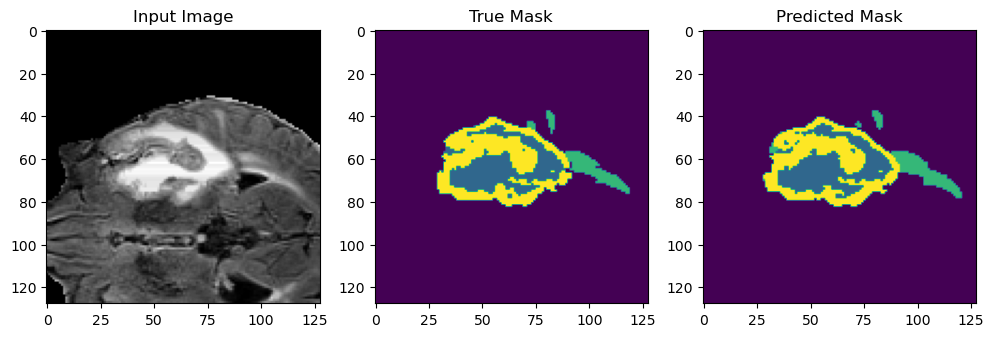

In [106]:
slice_index = 55
inputs = test_image_batch[0]
true_mask = test_mask_batch_argmax[0]
pred_mask = test_pred_batch_argmax[0]      
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(inputs[:, :, slice_index, 0], cmap='gray')
axes[0].set_title('Input Image')
axes[1].imshow(true_mask[:, :, slice_index])
axes[1].set_title('True Mask')
axes[2].imshow(pred_mask[:, :, slice_index])
axes[2].set_title('Predicted Mask')
plt.show()

#### Images generated to illustrate the data augmentation functions on the report

In [136]:
flair_image = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_flair.nii.gz').get_fdata()

crop_region = (slice(20, 220), slice(20, 220), slice(14, 142))

flair_original = flair_image[crop_region]

In [31]:
def flip_image(flair, axis):
    if (axis == 'x'):
        flair = np.flip(flair, axis=0)
    if (axis == 'y'):
        flair = np.flip(flair, axis=1)
    return flair

In [42]:
#flair_cropped = test_image_flair[crop_region]
flair_image = flair_image[crop_region]
flair_x = flip_image(flair_image, 'x')
flair_y = flip_image(flair_image, 'y')

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(flair_image[:, :, 55], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(flair_x[:, :, 55], cmap='gray')
axes[1].set_title('Flipped on X axis')
axes[2].imshow(flair_y[:, :, 55], cmap='gray')
axes[2].set_title('Flipped on Y axis')
plt.tight_layout()
plt.show()

In [43]:
def brightness_alter(flair, factor):
    flair = np.sign(flair) * factor * (np.abs(flair) ** factor)
    return flair

In [56]:
flair_high = brightness_alter(flair_image, 0.5)
flair_low = brightness_alter(flair_image, 1.75)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(flair_image[:, :, 55], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(flair_low[:, :, 55], cmap='gray')
axes[1].set_title('Low brightness')
axes[2].imshow(flair_high[:, :, 55], cmap='gray')
axes[2].set_title('High brightness')
plt.tight_layout()
plt.show()

In [58]:
def apply_contrast(data_sample, factor):
    # applies the contrast change to each channel
    for c in range(data_sample.shape[0]):
        # calculates the mean, minimum, and maximum of the current channel
        mn = data_sample[c].mean()
        minm = data_sample[c].min()
        maxm = data_sample[c].max()
        
        # adjusts the contrast and ensure values remain within the original data range
        data_sample[c] = (data_sample[c] - mn) * factor + mn
        # clips values below the original minimum
        data_sample[c][data_sample[c] < minm] = minm
        # clips values above the original maximum
        data_sample[c][data_sample[c] > maxm] = maxm
    
    # returns the image with the contrast change applied
    return data_sample

In [60]:
def contrast_alter(flair, factor):
    flair = apply_contrast(flair, factor)
    return flair

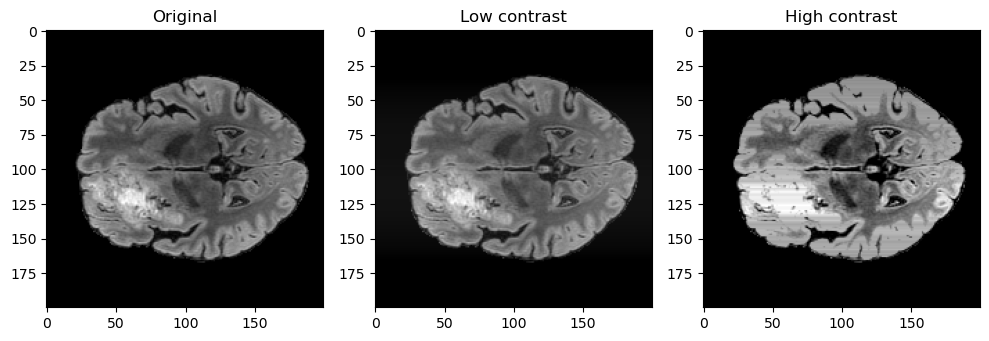

In [141]:
flair_high = apply_contrast(flair_original.copy(), 2)
flair_low = apply_contrast(flair_original.copy(), 0.75)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(flair_original[:, :, 55], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(flair_low[:, :, 55], cmap='gray')
axes[1].set_title('Low contrast')
axes[2].imshow(flair_high[:, :, 55], cmap='gray')
axes[2].set_title('High contrast')
plt.tight_layout()
plt.show()

In [152]:
def gaussian_noise(flair, noise_variance):
    for c in range(flair.shape[0]):
            variance_here = noise_variance
            flair[c] = flair[c] + np.random.normal(0.0, variance_here, size=flair[c].shape)
    return flair

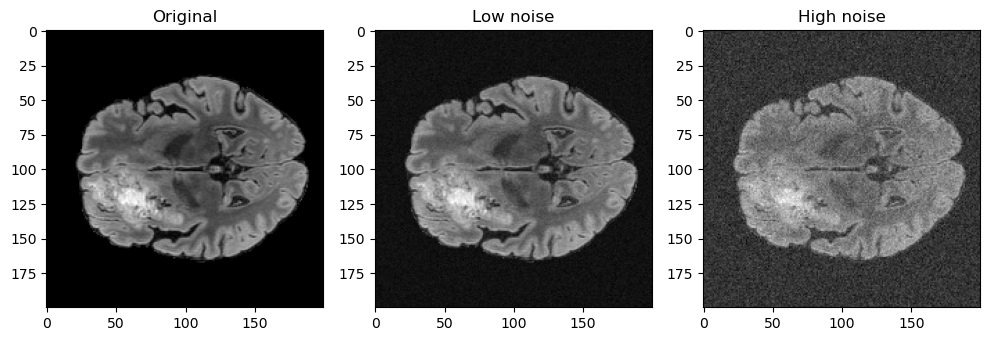

In [153]:
flair_high = gaussian_noise(flair_original.copy(), 200)
flair_low = gaussian_noise(flair_original.copy(), 50)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(flair_original[:, :, 55], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(flair_low[:, :, 55], cmap='gray')
axes[1].set_title('Low noise')
axes[2].imshow(flair_high[:, :, 55], cmap='gray')
axes[2].set_title('High noise')
plt.tight_layout()
plt.show()

In [147]:
def gaussian_blur(flair, sigma):
    flair = gaussian_filter(flair, sigma)
    return flair

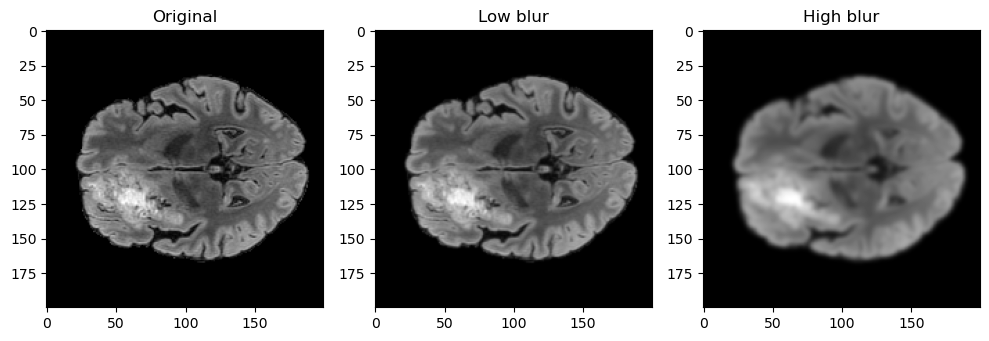

In [149]:
flair_high = gaussian_blur(flair_original.copy(), 1.5)
flair_low = gaussian_blur(flair_original.copy(), 0.5)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(flair_original[:, :, 55], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(flair_low[:, :, 55], cmap='gray')
axes[1].set_title('Low blur')
axes[2].imshow(flair_high[:, :, 55], cmap='gray')
axes[2].set_title('High blur')
plt.tight_layout()
plt.show()

#### Image to visualize cropping

In [24]:
flair_image = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_flair.nii.gz').get_fdata()
mask_image = nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_seg.nii.gz').get_fdata()

In [25]:
top, bottom, left, right = calculate_coords(mask_image, 'tumor')
flair_tumor = flair_image[top:bottom, left:right, 14:142]
top, bottom, left, right = calculate_coords(mask_image, 'center')
flair_center = flair_image[top:bottom, left:right, 14:142]

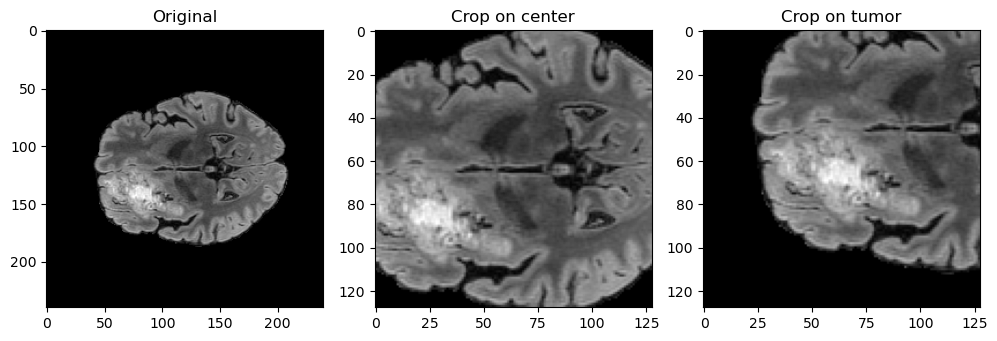

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(flair_image[:, :, 69], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(flair_center[:, :, 55], cmap='gray')
axes[1].set_title('Crop on center')
axes[2].imshow(flair_tumor[:, :, 55], cmap='gray')
axes[2].set_title('Crop on tumor')
plt.tight_layout()
plt.show()

#### References: 
- https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/augmentations
- https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
- https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/losses.py
- https://github.com/bnsreenu/python_for_microscopists/